In [2]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
data = pd.read_csv('beginning_sample.csv')

In [5]:
pickle.dump(data, open('db.pickle', 'wb'))

In [6]:
data = pickle.load(open('db.pickle', 'rb'))

In [7]:
data.subreddit.value_counts()

politics                1286712
The_Donald               817118
worldnews                585547
funny                    580616
news                     580117
gaming                   481149
pcgaming                  76677
ukpolitics                73542
AskReddit                 57124
Conservative              57087
newsokur                  36622
newsokunomoral            22682
AskScienceFiction         21489
pcmasterrace              16477
truegaming                15307
SandersForPresident       12097
willis7737_news           10242
worldpolitics             10234
videos                    10129
PoliticalDiscussion        9886
linux_gaming               9604
leagueoflegends            8344
todayilearned              8323
Overwatch                  8050
movies                     7860
gamingsuggestions          7766
buildapc                   7635
pics                       7059
nba                        6732
retrogaming                6449
                         ...   
meteorit

In [8]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [9]:
sub_list = ['politics']

data = data[data['subreddit'].isin(sub_list)]

In [10]:
data.head()

,_id,author,author_flair_text,body,can_gild,collapsed,collapsed_reason,controversiality,created_utc,distinguished,...,gilded,id,is_submitter,link_id,parent_id,retrieved_on,score,stickied,subreddit,subreddit_id
3,ObjectId(5d5a006b42ec30098280ce9a),NaN,NaN,A few people were even claiming in 2012 that T...,NaN,NaN,NaN,0,1462060800,NaN,...,0,d2nvjj9,NaN,t3_4h4r9p,t1_d2nvgh5,1465550534,1,False,politics,t5_2cneq
14,ObjectId(5d5a006b42ec30098280cea5),NaN,NaN,I know you blame others for your problems. Ha...,NaN,NaN,NaN,1,1462060805,NaN,...,0,d2nvjmo,NaN,t3_4h6qba,t1_d2nvgzj,1465550535,1,False,politics,t5_2cneq
21,ObjectId(5d5a006b42ec30098280ceac),NaN,NaN,Does it come with an unearned seat in the Senate?,NaN,NaN,NaN,0,1462060809,NaN,...,0,d2nvjp1,NaN,t3_4h6e5h,t3_4h6e5h,1465550536,0,False,politics,t5_2cneq
30,ObjectId(5d5a006b42ec30098280ceb5),NaN,NaN,[removed],NaN,NaN,NaN,0,1462060814,NaN,...,0,d2nvjta,NaN,t3_4h6eb0,t1_d2nu1dh,1465550537,-5,False,politics,t5_2cneq
38,ObjectId(5d5a006b42ec30098280cebd),NaN,NaN,"No, it's about destroying public education to ...",NaN,NaN,NaN,0,1462060819,NaN,...,0,d2nvjwi,NaN,t3_4h6r3n,t3_4h6r3n,1465550539,1,False,politics,t5_2cneq


In [11]:
data = data[['body','controversiality','gilded','score','subreddit']]

In [12]:
data.head()

,body,controversiality,gilded,score,subreddit
3,A few people were even claiming in 2012 that T...,0,0,1,politics
14,I know you blame others for your problems. Ha...,1,0,1,politics
21,Does it come with an unearned seat in the Senate?,0,0,0,politics
30,[removed],0,0,-5,politics
38,"No, it's about destroying public education to ...",0,0,1,politics


In [13]:
len(data)

1286712

In [14]:
data = data[data['score']>50]

In [15]:
len(data)

20199

In [16]:
score_df = data.sort_values(by='score',ascending = False)

In [17]:
score_df.head()

,body,controversiality,gilded,score,subreddit
4204032,"&gt;""Honestly, I mean, I just believe that thi...",0,1,5567,politics
4966259,Trump's supporters said Trump was a genius for...,0,0,5276,politics
550099,I just want to remind everyone of something.\n...,0,6,5226,politics
884430,Then why the fuck are people voting for them?,0,1,4938,politics
544956,Reminder that Kasich is now 4th place in a 2 m...,0,0,4796,politics


In [18]:
counter = 0
for row in score_df['body']:
    if row == '[deleted]':
        score_df.drop()
        counter += 1
print(counter)

ValueError: Need to specify at least one of 'labels', 'index' or 'columns'

In [19]:
len(score_df)

20199

In [20]:
score_df = score_df[score_df['body'] != '[deleted]']

In [21]:
for index in score_df.index.values:
    test = score_df.loc[index,'body'].split()
    print(len(test))

83
31
425
9
12
1484
67
12
290
28
7
24
9
34
306
26
41
86
1
43
662
8
10
1612
57
37
46
13
87
4
90
273
22
27
13
4
28
133
34
16
18
26
30
115
22
16
26
10
2
7
58
57
32
173
20
1
13
102
9
95
19
88
1
38
1
33
209
13
12
31
50
36
19
28
30
10
26
1485
47
56
2
95
18
51
1
49
12
31
23
33
23
37
54
1
1437
18
58
63
46
23
38
27
59
5
40
21
22
81
79
122
49
52
216
3
10
14
52
20
12
3
437
13
29
64
194
21
17
74
6
30
36
19
70
43
188
32
16
91
10
35
15
15
44
199
19
21
39
77
52
97
25
6
33
12
6
20
1
17
29
17
158
33
97
42
15
29
26
15
8
12
21
1
14
24
15
61
26
10
41
10
64
11
40
19
20
64
18
43
105
12
8
81
9
14
6
18
96
139
881
1
27
84
13
7
31
44
17
29
28
117
15
12
35
14
58
6
81
79
83
97
33
11
39
10
860
14
10
163
57
107
219
15
15
17
49
8
30
24
210
55
11
15
8
50
41
62
10
342
49
19
21
11
27
83
67
731
20
22
11
19
21
4
27
29
349
122
36
10
222
22
10
24
380
49
2
14
56
13
8
79
22
115
14
885
23
146
1
107
4
8
88
31
31
9
21
12
1
1
24
35
59
10
108
8
11
28
47
8
784
7
1
50
36
76
6
2
22
77
14
11
64
2
32
5
29
330
49
66
128
17
84
35
365
28

127
158
12
42
9
83
111
43
50
58
24
6
12
29
5
71
3
17
20
12
27
16
233
70
102
7
367
17
36
10
42
35
17
77
455
8
66
46
29
31
181
1
55
14
39
12
44
11
18
9
1
11
1
80
51
21
16
49
20
3
33
8
6
54
13
13
424
22
56
9
57
44
16
33
14
35
37
6
8
1
22
83
6
6
9
4
57
7
17
179
19
32
21
11
129
9
22
63
21
16
12
329
191
53
5
116
23
14
20
28
1
8
55
6
112
13
126
29
5
32
6
78
15
27
15
20
124
20
79
6
10
56
9
15
68
32
15
1
43
3
24
10
42
38
19
179
35
8
52
8
20
31
54
26
33
128
86
9
20
43
3
55
24
15
20
74
31
4
54
28
49
22
32
9
266
43
28
67
63
57
14
52
10
6
2
32
19
2
34
56
23
81
82
25
32
26
108
12
12
41
9
32
19
20
27
70
10
47
20
51
43
40
165
27
21
20
7
4
22
6
36
26
9
15
65
3
29
98
9
15
15
21
14
17
164
17
22
21
51
6
15
19
20
38
16
108
3
41
144
44
72
15
27
22
5
84
8
17
49
1
60
44
4
13
33
1
149
1
23
14
31
46
63
24
8
103
1
6
8
125
12
28
39
30
39
28
15
141
25
7
74
17
3
31
99
37
22
35
11
76
40
10
14
45
65
48
31
12
25
6
42
19
54
38
28
24
9
24
5
55
9
33
16
19
17
25
44
71
36
27
46
1
76
71
10
11
106
14
60
14
12
1303
11
58
168


AttributeError: 'float' object has no attribute 'split'

In [22]:
score_df['body_length'] = score_df['body'].apply(lambda x: len(str(x).split(' ')))

In [23]:
score_df = score_df[score_df['body_length'] >= 5]

In [24]:
len(score_df)

18469

### Manipulation

In [25]:
score_df.head()

,body,controversiality,gilded,score,subreddit,body_length
4204032,"&gt;""Honestly, I mean, I just believe that thi...",0,1,5567,politics,82
4966259,Trump's supporters said Trump was a genius for...,0,0,5276,politics,32
550099,I just want to remind everyone of something.\n...,0,6,5226,politics,419
884430,Then why the fuck are people voting for them?,0,1,4938,politics,9
544956,Reminder that Kasich is now 4th place in a 2 m...,0,0,4796,politics,12


In [26]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(score_df['body']))

In [27]:
data_words[1]

['trump',
 'supporters',
 'said',
 'trump',
 'was',
 'genius',
 'for',
 'agreeing',
 'to',
 'sanders',
 'proposal',
 'for',
 'debate',
 'now',
 'just',
 'watch',
 'as',
 'his',
 'supporters',
 'explain',
 'that',
 'trump',
 'genius',
 'for',
 'turning',
 'down',
 'sanders',
 'proposal']

In [28]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [29]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram[bigram[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [30]:
stop_words.extend(['http', 'https', 'imgur', 'com', 'jpg', 'bernie', 'hillary', 'trump', 'www', 'sander', 'sanders', 'clinton', 'donald', 'youtube'])

In [31]:
stop_words.extend(['reddit', 'org'])

In [32]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.

trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

/home/nick/anaconda3/lib/python3.7/site-packages/gensim/models/phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [33]:
print(trigram[bigram[data_words[19]]])

['editing', 'as', 'new', 'outlets', 'report', 'on', 'the', 'story', 'keep', 'hitting', 'the', 'character', 'post', 'limit', 'you', 'can', 'see', 'the', 'big', 'list', 'here', 'google', 'doc', 'https', 'docs_google', 'com', 'spreadsheets', 'lhcoacw', 'nd', 'xpmrgbqsssw', 'epg', 'adm', 'ihdes', 'edit', 'usp', 'sharing', 'also', 'thanks', 'for', 'the', 'gold', 'you', 'know', 'who', 'you', 'are', 'news', 'outlet', 'headline', 'link', 'politico', 'state_dept_watchdog', 'clinton', 'violated', 'email', 'rules', 'http_www', 'politico', 'com', 'story', 'hillary', 'clinton', 'email', 'inspector_general_report', 'politico', 'clinton', 'expressed', 'worries', 'about', 'exposure', 'of', 'personal', 'emails', 'at', 'state_dept', 'http_www', 'politico', 'com', 'story', 'hillary', 'clinton', 'personal', 'email', 'worry', 'politico', 'republicans', 'rip', 'clinton', 'after', 'ig', 'email', 'report', 'http_www', 'politico', 'com', 'story', 'hillary', 'clinton', 'email', 'report', 'gop', 'politico', 'cli

In [34]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Form Trigrams
data_words_trigrams = make_trigrams(data_words_bigrams)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['honestly', 'mean', 'believe', 'important', 'job', 'world', 'toughest_job', 'world', 'willing', 'campaign', 'vote', 'willing', 'think', 'interesting_juxtaposition', 'find', 'know', 'willing', 'entire', 'process', 'people', 'try', 'push', 'ever', 'iowa']]


In [35]:
pickle.dump(data_lemmatized, open('lem.pickle', 'wb'))

In [36]:
import pickle 
data_lemmatized2 = pickle.load(open('lem.pickle', 'rb'))

In [37]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized2)

# Create Corpus
texts = data_lemmatized2

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 3), (20, 2)]]


In [38]:
#Readable version:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('believe', 1),
  ('campaign', 1),
  ('entire', 1),
  ('ever', 1),
  ('find', 1),
  ('honestly', 1),
  ('important', 1),
  ('interesting_juxtaposition', 1),
  ('iowa', 1),
  ('job', 1),
  ('know', 1),
  ('mean', 1),
  ('people', 1),
  ('process', 1),
  ('push', 1),
  ('think', 1),
  ('toughest_job', 1),
  ('try', 1),
  ('vote', 1),
  ('willing', 3),
  ('world', 2)]]

In [39]:
score_df['processed_body'] = data_lemmatized2

In [40]:
pickle.dump(score_df, open('score_df.pickle', 'wb'))

In [41]:
score_df = pickle.load(open('score_df.pickle', 'rb'))

In [49]:
score_df.head()

,body,controversiality,gilded,score,subreddit,body_length,processed_body
4204032,"&gt;""Honestly, I mean, I just believe that thi...",0,1,5567,politics,82,"[honestly, mean, believe, important, job, worl..."
4966259,Trump's supporters said Trump was a genius for...,0,0,5276,politics,32,"[supporter, say, genius, agree, proposal, deba..."
550099,I just want to remind everyone of something.\n...,0,6,5226,politics,419,"[want, remind, everyone, something, loathsome,..."
884430,Then why the fuck are people voting for them?,0,1,4938,politics,9,"[fuck, people, vote]"
544956,Reminder that Kasich is now 4th place in a 2 m...,0,0,4796,politics,12,"[reminder, place, man, race]"


### Building the Topic Model

In [50]:
from gensim import corpora, models
lda_model = models.LdaMulticore(corpus, id2word=id2word, num_topics=8, workers=7)

In [61]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

2019-08-22 06:33:20,239 : INFO : -8.339 per-word bound, 323.8 perplexity estimate based on a held-out corpus of 18469 documents with 384600 words



Perplexity:  -8.339149856287031


In [63]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized2, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

2019-08-22 06:33:36,593 : INFO : using ParallelWordOccurrenceAccumulator(processes=31, batch_size=64) to estimate probabilities from sliding windows
2019-08-22 06:33:39,560 : INFO : serializing accumulator to return to master...
2019-08-22 06:33:39,569 : INFO : serializing accumulator to return to master...
2019-08-22 06:33:39,566 : INFO : serializing accumulator to return to master...
2019-08-22 06:33:39,566 : INFO : serializing accumulator to return to master...
2019-08-22 06:33:39,564 : INFO : serializing accumulator to return to master...
2019-08-22 06:33:39,577 : INFO : serializing accumulator to return to master...
2019-08-22 06:33:39,580 : INFO : accumulator serialized
2019-08-22 06:33:39,563 : INFO : serializing accumulator to return to master...
2019-08-22 06:33:39,581 : INFO : accumulator serialized
2019-08-22 06:33:39,580 : INFO : accumulator serialized
2019-08-22 06:33:39,582 : INFO : accumulator serialized
2019-08-22 06:33:39,585 : INFO : serializing accumulator to return 


Coherence Score:  0.4599709957738477


### Visualization Topics

In [44]:
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

In [56]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/home/nick/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.013017 -0.001584       1        1  15.821816
0     -0.020129 -0.005958       2        1  15.752447
1     -0.020783 -0.012479       3        1  14.514865
7     -0.004662  0.005674       4        1  13.418362
5     -0.000221  0.019797       5        1  11.775090
6     -0.008251 -0.004214       6        1  10.143923
3      0.028542  0.035698       7        1  10.107410
2      0.038520 -0.036935       8        1   8.466083, topic_info=     Category         Freq              Term        Total  loglift  logprob
191   Default  2960.000000             would  2960.000000  30.0000  30.0000
18    Default  2721.000000              vote  2721.000000  29.0000  29.0000
291   Default  3421.000000               get  3421.000000  28.0000  28.0000
175   Default  1619.000000              time  1619.000000  27.0000  27.0000
15    Default  2101.000000             think  2101.000000  26.0000  26.0000
12    Default  3397.000000            people  3397.000000  25.0000  25.0000
456   Default  1257.000000               use  1257.000000  24.0000  24.0000
27    Default  1541.000000         supporter  1541.000000  23.0000  23.0000
26    Default  3316.000000               say  3316.000000  22.0000  22.0000
93    Default  2939.000000                go  2939.000000  21.0000  21.0000
10    Default  1648.000000              know  1648.000000  20.0000  20.0000
437   Default  1532.000000             state  1532.000000  19.0000  19.0000
113   Default  1031.000000              look  1031.000000  18.0000  18.0000
11    Default   828.000000              mean   828.000000  17.0000  17.0000
139   Default   576.000000              post   576.000000  16.0000  16.0000
269   Default  1547.000000             email  1547.000000  15.0000  15.0000
1064  Default   660.000000             obama   660.000000  14.0000  14.0000
376   Default   241.000000  politics_comment   241.000000  13.0000  13.0000
76    Default  1745.000000              even  1745.000000  12.0000  12.0000
125   Default  1001.000000              much  1001.000000  11.0000  11.0000
528   Default   636.000000               pay   636.000000  10.0000  10.0000
157   Default  1487.000000               see  1487.000000   9.0000   9.0000
802   Default   616.000000              news   616.000000   8.0000   8.0000
168   Default  1229.000000              take  1229.000000   7.0000   7.0000
187   Default  1090.000000               win  1090.000000   6.0000   6.0000
620   Default  1242.000000              good  1242.000000   5.0000   5.0000
294   Default  1467.000000                gt  1467.000000   4.0000   4.0000
395   Default  1151.000000            really  1151.000000   3.0000   3.0000
334   Default   522.000000               lie   522.000000   2.0000   2.0000
374   Default   817.000000           politic   817.000000   1.0000   1.0000
...       ...          ...               ...          ...      ...      ...
594    Topic8    71.557373           comment   437.774017   0.6579  -6.1204
123    Topic8    97.949081             money   718.567993   0.4763  -5.8064
403    Topic8    78.869301            report   519.729065   0.5836  -6.0231
125    Topic8   118.657600              much  1001.619568   0.3360  -5.6146
113    Topic8   120.419044              look  1031.892944   0.3209  -5.5999
189    Topic8    60.641483              word   368.273499   0.6653  -6.2859
294    Topic8   144.993881                gt  1467.713379   0.1543  -5.4142
620    Topic8   126.161110              good  1242.849121   0.1815  -5.5533
15     Topic8   174.324799             think  2101.445068  -0.0204  -5.2299
115    Topic8   174.889008              make  2190.975586  -0.0588  -5.2267
422    Topic8    79.219559              seem   616.813721   0.4168  -6.0186
27     Topic8   134.426804         supporter  1541.644531   0.0295  -5.4898
61     Topic8   103.651215              come  1011.344849   0.1911  -5.74

### Mallet Model

In [46]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
mallet_path = '/home/nick/Documents/metis/project_04_final/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=8, id2word=id2word)

In [47]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=texts, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('money', 0.017650909430962734),
   ('pay', 0.014822088184411091),
   ('american', 0.013816804600925795),
   ('job', 0.013255716089213073),
   ('work', 0.01038013746668537),
   ('year', 0.010029457146864918),
   ('make', 0.00848646373965493),
   ('country', 0.00820591948379857),
   ('high', 0.007621452284097816),
   ('give', 0.007270771964277365)]),
 (1,
  [('time', 0.028463838741831875),
   ('politic', 0.023784472256063796),
   ('article', 0.02217853582899546),
   ('campaign', 0.01849595747037324),
   ('news', 0.01827444899767416),
   ('post', 0.016834643925130136),
   ('woman', 0.015976298593421197),
   ('man', 0.013844279543692547),
   ('watch', 0.012653671502934987),
   ('make', 0.012598294384760218)]),
 (2,
  [('debate', 0.030536281147287694),
   ('make', 0.02435598505492036),
   ('give', 0.017023906508975475),
   ('start', 0.016602522684495885),
   ('lie', 0.015647386015675478),
   ('good', 0.015619293760710173),
   ('agree', 0.012051577380116302),
   ('put', 0.0116301935

### Optimal Topics

In [72]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [73]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=40, step=6)

2019-08-22 07:02:43,543 : INFO : serializing temporary corpus to /tmp/6e7ac7_corpus.txt
2019-08-22 07:02:44,111 : INFO : converting temporary corpus to MALLET format with /data/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input /tmp/6e7ac7_corpus.txt --output /tmp/6e7ac7_corpus.mallet
2019-08-22 07:02:45,689 : INFO : training MALLET LDA with /data/mallet-2.0.8/bin/mallet train-topics --input /tmp/6e7ac7_corpus.mallet --num-topics 2  --alpha 50 --optimize-interval 0 --num-threads 4 --output-state /tmp/6e7ac7_state.mallet.gz --output-doc-topics /tmp/6e7ac7_doctopics.txt --output-topic-keys /tmp/6e7ac7_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/6e7ac7_inferencer.mallet --doc-topics-threshold 0.0  --random-seed 0
2019-08-22 07:03:21,200 : INFO : loading assigned topics from /tmp/6e7ac7_state.mallet.gz
2019-08-22 07:03:23,548 : INFO : using ParallelWordOccurrenceAccumulator(processes=31, batch_size=64) to es

2019-08-22 07:04:11,566 : INFO : accumulator serialized
2019-08-22 07:04:11,573 : INFO : accumulator serialized
2019-08-22 07:04:11,553 : INFO : serializing accumulator to return to master...
2019-08-22 07:04:11,540 : INFO : serializing accumulator to return to master...
2019-08-22 07:04:11,559 : INFO : serializing accumulator to return to master...
2019-08-22 07:04:11,530 : INFO : serializing accumulator to return to master...
2019-08-22 07:04:11,531 : INFO : serializing accumulator to return to master...
2019-08-22 07:04:11,552 : INFO : serializing accumulator to return to master...
2019-08-22 07:04:11,530 : INFO : serializing accumulator to return to master...
2019-08-22 07:04:11,581 : INFO : serializing accumulator to return to master...
2019-08-22 07:04:11,542 : INFO : serializing accumulator to return to master...
2019-08-22 07:04:11,530 : INFO : serializing accumulator to return to master...
2019-08-22 07:04:11,566 : INFO : serializing accumulator to return to master...
2019-08-

2019-08-22 07:05:05,176 : INFO : training MALLET LDA with /data/mallet-2.0.8/bin/mallet train-topics --input /tmp/90982c_corpus.mallet --num-topics 20  --alpha 50 --optimize-interval 0 --num-threads 4 --output-state /tmp/90982c_state.mallet.gz --output-doc-topics /tmp/90982c_doctopics.txt --output-topic-keys /tmp/90982c_topickeys.txt --num-iterations 1000 --inferencer-filename /tmp/90982c_inferencer.mallet --doc-topics-threshold 0.0  --random-seed 0
2019-08-22 07:05:42,408 : INFO : loading assigned topics from /tmp/90982c_state.mallet.gz
2019-08-22 07:05:44,788 : INFO : using ParallelWordOccurrenceAccumulator(processes=31, batch_size=64) to estimate probabilities from sliding windows
2019-08-22 07:05:48,876 : INFO : serializing accumulator to return to master...
2019-08-22 07:05:48,883 : INFO : serializing accumulator to return to master...
2019-08-22 07:05:48,883 : INFO : serializing accumulator to return to master...
2019-08-22 07:05:48,890 : INFO : serializing accumulator to return 

2019-08-22 07:06:41,954 : INFO : serializing accumulator to return to master...
2019-08-22 07:06:41,948 : INFO : accumulator serialized
2019-08-22 07:06:42,017 : INFO : serializing accumulator to return to master...
2019-08-22 07:06:42,025 : INFO : serializing accumulator to return to master...
2019-08-22 07:06:42,020 : INFO : accumulator serialized
2019-08-22 07:06:41,881 : INFO : serializing accumulator to return to master...
2019-08-22 07:06:42,036 : INFO : accumulator serialized
2019-08-22 07:06:41,974 : INFO : serializing accumulator to return to master...
2019-08-22 07:06:42,042 : INFO : serializing accumulator to return to master...
2019-08-22 07:06:42,051 : INFO : serializing accumulator to return to master...
2019-08-22 07:06:41,832 : INFO : accumulator serialized
2019-08-22 07:06:42,055 : INFO : accumulator serialized
2019-08-22 07:06:42,116 : INFO : serializing accumulator to return to master...
2019-08-22 07:06:41,845 : INFO : accumulator serialized
2019-08-22 07:06:42,131 

2019-08-22 07:08:29,505 : INFO : loading assigned topics from /tmp/51bb6b_state.mallet.gz
2019-08-22 07:08:31,886 : INFO : using ParallelWordOccurrenceAccumulator(processes=31, batch_size=64) to estimate probabilities from sliding windows
2019-08-22 07:08:37,360 : INFO : serializing accumulator to return to master...
2019-08-22 07:08:37,364 : INFO : serializing accumulator to return to master...
2019-08-22 07:08:37,375 : INFO : accumulator serialized
2019-08-22 07:08:37,375 : INFO : serializing accumulator to return to master...
2019-08-22 07:08:37,376 : INFO : accumulator serialized
2019-08-22 07:08:37,380 : INFO : accumulator serialized
2019-08-22 07:08:37,378 : INFO : serializing accumulator to return to master...
2019-08-22 07:08:37,400 : INFO : serializing accumulator to return to master...
2019-08-22 07:08:37,408 : INFO : accumulator serialized
2019-08-22 07:08:37,419 : INFO : serializing accumulator to return to master...
2019-08-22 07:08:37,416 : INFO : serializing accumulator 

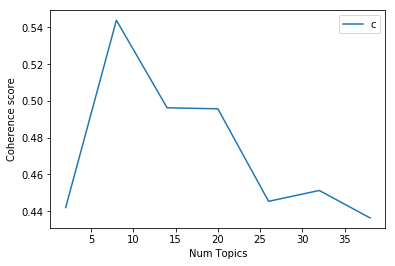

In [77]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### Rerun LDA with Optimal Number of Topics

In [80]:
optimal_model = models.LdaMulticore(corpus, id2word=id2word, num_topics=8, workers=31)

2019-08-22 07:27:48,501 : INFO : using symmetric alpha at 0.125
2019-08-22 07:27:48,503 : INFO : using symmetric eta at 0.125
2019-08-22 07:27:48,507 : INFO : using serial LDA version on this node
2019-08-22 07:27:48,534 : INFO : running online LDA training, 8 topics, 1 passes over the supplied corpus of 18469 documents, updating every 62000 documents, evaluating every ~18469 documents, iterating 50x with a convergence threshold of 0.001000
2019-08-22 07:27:48,535 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2019-08-22 07:27:48,537 : INFO : training LDA model using 31 processes
2019-08-22 07:27:50,792 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/18469, outstanding queue size 1
2019-08-22 07:27:50,973 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/18469, outstanding queue size 2
2019-08-22 07:27:51,004 : INFO : PROGRESS: pass 0, dispatched chunk #2 = 

In [81]:
optimal_model.print_topics(num_words=10)

2019-08-22 07:28:52,265 : INFO : topic #0 (0.125): 0.016*"go" + 0.012*"get" + 0.009*"make" + 0.007*"would" + 0.007*"see" + 0.006*"think" + 0.006*"campaign" + 0.005*"people" + 0.005*"candidate" + 0.005*"say"
2019-08-22 07:28:52,267 : INFO : topic #1 (0.125): 0.011*"get" + 0.011*"people" + 0.010*"want" + 0.007*"say" + 0.006*"would" + 0.006*"good" + 0.006*"use" + 0.005*"vote" + 0.005*"think" + 0.005*"party"
2019-08-22 07:28:52,268 : INFO : topic #2 (0.125): 0.014*"say" + 0.013*"would" + 0.012*"think" + 0.010*"vote" + 0.010*"people" + 0.006*"state" + 0.006*"go" + 0.005*"supporter" + 0.005*"want" + 0.005*"thing"
2019-08-22 07:28:52,270 : INFO : topic #3 (0.125): 0.014*"get" + 0.008*"people" + 0.008*"say" + 0.008*"make" + 0.007*"would" + 0.007*"vote" + 0.006*"know" + 0.005*"time" + 0.005*"email" + 0.005*"go"
2019-08-22 07:28:52,272 : INFO : topic #4 (0.125): 0.010*"people" + 0.008*"say" + 0.007*"know" + 0.006*"would" + 0.006*"thing" + 0.006*"see" + 0.005*"medium" + 0.005*"article" + 0.005*"e

[(0,
  '0.016*"go" + 0.012*"get" + 0.009*"make" + 0.007*"would" + 0.007*"see" + 0.006*"think" + 0.006*"campaign" + 0.005*"people" + 0.005*"candidate" + 0.005*"say"'),
 (1,
  '0.011*"get" + 0.011*"people" + 0.010*"want" + 0.007*"say" + 0.006*"would" + 0.006*"good" + 0.006*"use" + 0.005*"vote" + 0.005*"think" + 0.005*"party"'),
 (2,
  '0.014*"say" + 0.013*"would" + 0.012*"think" + 0.010*"vote" + 0.010*"people" + 0.006*"state" + 0.006*"go" + 0.005*"supporter" + 0.005*"want" + 0.005*"thing"'),
 (3,
  '0.014*"get" + 0.008*"people" + 0.008*"say" + 0.008*"make" + 0.007*"would" + 0.007*"vote" + 0.006*"know" + 0.005*"time" + 0.005*"email" + 0.005*"go"'),
 (4,
  '0.010*"people" + 0.008*"say" + 0.007*"know" + 0.006*"would" + 0.006*"thing" + 0.006*"see" + 0.005*"medium" + 0.005*"article" + 0.005*"email" + 0.004*"get"'),
 (5,
  '0.010*"people" + 0.010*"vote" + 0.008*"get" + 0.007*"would" + 0.007*"party" + 0.006*"say" + 0.006*"win" + 0.005*"go" + 0.005*"even" + 0.005*"really"'),
 (6,
  '0.009*"say" 

In [129]:
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
vis

/home/ubuntu/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.011840  0.001169       1        1  15.205505
0     -0.011126  0.027197       2        1  15.097112
6      0.007325  0.006780       3        1  14.982555
7      0.001319  0.009859       4        1  12.470545
4      0.031839 -0.027959       5        1  11.618389
3      0.008730  0.004023       6        1  11.370793
1      0.010591  0.007016       7        1   9.943889
5     -0.036837 -0.028084       8        1   9.311213, topic_info=     Category         Freq        Term        Total  loglift  logprob
18    Default  2673.000000        vote  2673.000000  30.0000  30.0000
93    Default  2936.000000          go  2936.000000  29.0000  29.0000
291   Default  3385.000000         get  3385.000000  28.0000  28.0000
184   Default  1660.000000        want  1660.000000  27.0000  27.0000
10    Default  1664.000000        know  1664.000000  26.0000  26.0000
133   Default  1332.000000       party  1332.000000  25.0000  25.0000
15    Default  2110.000000       think  2110.000000  24.0000  24.0000
12    Default  3356.000000      people  3356.000000  23.0000  23.0000
188   Default   538.000000       woman   538.000000  22.0000  22.0000
26    Default  3342.000000         say  3342.000000  21.0000  21.0000
620   Default  1219.000000        good  1219.000000  20.0000  20.0000
755   Default   623.000000         fbi   623.000000  19.0000  19.0000
187   Default  1083.000000         win  1083.000000  18.0000  18.0000
456   Default  1262.000000         use  1262.000000  17.0000  17.0000
269   Default  1614.000000       email  1614.000000  16.0000  16.0000
523   Default   703.000000      medium   703.000000  15.0000  15.0000
395   Default  1133.000000      really  1133.000000  14.0000  14.0000
139   Default   572.000000        post   572.000000  13.0000  13.0000
528   Default   623.000000         pay   623.000000  12.0000  12.0000
352   Default   999.000000        need   999.000000  11.0000  11.0000
802   Default   628.000000        news   628.000000  10.0000  10.0000
215   Default   770.000000     article   770.000000   9.0000   9.0000
160   Default   727.000000     someone   727.000000   8.0000   8.0000
1064  Default   643.000000       obama   643.000000   7.0000   7.0000
374   Default   818.000000     politic   818.000000   6.0000   6.0000
17    Default   869.000000         try   869.000000   5.0000   5.0000
1455  Default   623.000000    delegate   623.000000   4.0000   4.0000
1156  Default   533.000000        sure   533.000000   3.0000   3.0000
157   Default  1510.000000         see  1510.000000   2.0000   2.0000
480   Default   878.000000         run   878.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
190    Topic8   144.972900        work   948.996338   0.4951  -5.5095
448    Topic8   101.910492      system   599.505859   0.6019  -5.8619
802    Topic8   104.789207        news   628.893677   0.5819  -5.8341
201    Topic8   132.251282    actually   895.305969   0.4615  -5.6013
374    Topic8   119.833549     politic   818.333923   0.4528  -5.6999
369    Topic8    81.371666        part   475.084961   0.6095  -6.0870
216    Topic8    79.023170         ask   456.270111   0.6206  -6.1163
334    Topic8    87.058708         lie   532.220947   0.5635  -6.0194
194    Topic8    79.423340         man   475.593384   0.5842  -6.1112
291    Topic8   297.934296         get  3385.683350  -0.0565  -4.7891
1350   Topic8    72.505821        care   424.670898   0.6063  -6.2023
191    Topic8   265.336578       would  2979.069580  -0.0444  -4.9050
341    Topic8   124.645653         may   969.846619   0.3223  -5.6605
76     Topic8   180.212341        even  1765.433594   0.0919  -5.2919
254    Topic8   102.975403  democratic   732.828308   0.4115  -5.8515
74     Topic8    98.632675        edit   690.713379   0.4276  -5.8946
175    Topic8   157.832169        time  1619.330200   0.0

### T-SNE

In [52]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    [topic_weights.append(w for i, w in row_list)]
#     topic_weights.append(row_list[0][1])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 8
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 18424 samples in 0.031s...
[t-SNE] Computed neighbors for 18424 samples in 0.848s...
[t-SNE] Computed conditional probabilities for sample 1000 / 18424
[t-SNE] Computed conditional probabilities for sample 2000 / 18424
[t-SNE] Computed conditional probabilities for sample 3000 / 18424
[t-SNE] Computed conditional probabilities for sample 4000 / 18424
[t-SNE] Computed conditional probabilities for sample 5000 / 18424
[t-SNE] Computed conditional probabilities for sample 6000 / 18424
[t-SNE] Computed conditional probabilities for sample 7000 / 18424
[t-SNE] Computed conditional probabilities for sample 8000 / 18424
[t-SNE] Computed conditional probabilities for sample 9000 / 18424
[t-SNE] Computed conditional probabilities for sample 10000 / 18424
[t-SNE] Computed conditional probabilities for sample 11000 / 18424
[t-SNE] Computed conditional probabilities for sample 12000 / 18424
[t-SNE] Computed conditional probabilities for sam

Loading BokehJS ...

In [54]:
print(mycolors)

['#1f77b4' '#ff7f0e' '#2ca02c' '#d62728' '#9467bd' '#8c564b' '#e377c2'
 '#7f7f7f' '#bcbd22' '#17becf']


In [127]:
# for i, row_list in enumerate(lda_model[corpus]):
#     print(row_list[0])
    
for i, row_list in enumerate(lda_model[corpus]):
    [print(w) for i, w in row_list]

0.9639802
0.9307329
0.23037206
0.4661351
0.04535219
0.034192126
0.13686188
0.08508254
0.025007224
0.77492404
0.025008364
0.025010068
0.02500549
0.025008615
0.025010014
0.025012655
0.025006332
0.02500716
0.0200153
0.020016486
0.020014662
0.020015499
0.020015785
0.8198647
0.020016134
0.020013789
0.020012446
0.020015154
0.9984191
0.3272452
0.6460612
0.016673815
0.016674154
0.016672757
0.016673932
0.01667377
0.8499354
0.01667208
0.016674515
0.016673492
0.016676053
0.4882537
0.45679566
0.04919431
0.3240298
0.6258807
0.033345785
0.033345316
0.033349354
0.033352196
0.033352192
0.033352852
0.033347107
0.03334929
0.6998564
0.03334953
0.34473565
0.59806323
0.014314738
0.014314362
0.014314574
0.01431514
0.014315186
0.014316251
0.87116593
0.014314362
0.014315391
0.0143140545
0.9436325
0.24348082
0.44115052
0.049118306
0.20225905
0.060406078
0.21071747
0.7320882
0.51405674
0.45627254
0.60427123
0.37217695
0.41608125
0.54177356
0.6820506
0.012904068
0.30402794
0.025008412
0.7749126
0.025009774
0.025

0.016697543
0.8497261
0.97997594
0.34560344
0.6301094
0.9639799
0.5249078
0.45766315
0.9436137
0.014307319
0.014306909
0.014309611
0.014307989
0.87122595
0.014309779
0.014307707
0.014309343
0.014307942
0.014307498
0.93989944
0.020003408
0.8199511
0.020005506
0.020006135
0.02000543
0.020004168
0.020006144
0.020005157
0.020004561
0.020008381
0.997824
0.014295914
0.25472414
0.01429517
0.014295216
0.014295163
0.01429595
0.63091063
0.014297051
0.014296221
0.0142945405
0.020012673
0.020018963
0.020013353
0.020013072
0.02001539
0.020014323
0.020015463
0.02001281
0.8198723
0.02001163
0.98813933
0.97094
0.42742294
0.4861412
0.07212653
0.23334323
0.59113437
0.16902882
0.0125144515
0.012515654
0.5260308
0.012514954
0.3738469
0.012515948
0.012515978
0.012514976
0.012515401
0.012514954
0.012526022
0.012524939
0.012525539
0.8872686
0.012525641
0.012526476
0.012525568
0.012525426
0.0125260325
0.01252578
0.01668414
0.016683485
0.3909344
0.016685806
0.016684921
0.016684894
0.016685827
0.01668482
0.0166

0.0100042205
0.010005525
0.010004775
0.010005038
0.9099555
0.010005593
0.010005073
0.010004318
0.010005211
0.010004806
0.98976076
0.28943068
0.67851746
0.95260525
0.28163895
0.69928545
0.21068667
0.7791756
0.014303211
0.014305933
0.014301715
0.014303254
0.014302145
0.01430343
0.0143017545
0.8712728
0.014303551
0.014302184
0.9653373
0.02506776
0.025067456
0.02506728
0.774381
0.02506772
0.025067994
0.025070379
0.025070973
0.025067104
0.025072372
0.014296563
0.87133074
0.014296263
0.014296405
0.014295847
0.014296905
0.014295867
0.014297815
0.014296334
0.014297264
0.95495546
0.9639533
0.01666923
0.0166705
0.016670616
0.016670488
0.016671324
0.016670518
0.01667034
0.016669622
0.016671402
0.84996593
0.94372016
0.01251584
0.012515259
0.012513705
0.012513419
0.012514595
0.01251409
0.012514146
0.51017976
0.38970464
0.012514538
0.025006944
0.025007263
0.02501126
0.7749219
0.02501047
0.025011225
0.025008561
0.025007198
0.025009213
0.025006011
0.020005582
0.020007707
0.020006452
0.020006148
0.0200

0.011122743
0.01112281
0.0111240465
0.011122131
0.0111225145
0.8998924
0.011123405
0.011122865
0.01112445
0.0111225955
0.012520088
0.01251878
0.012518333
0.0125186425
0.012518114
0.012519042
0.012518688
0.012518606
0.8873302
0.012519527
0.016673269
0.0166735
0.016673988
0.01667375
0.01667685
0.016673451
0.01667409
0.016673177
0.84993404
0.016673876
0.92495877
0.016676547
0.016676564
0.016677072
0.016676275
0.016677126
0.016678391
0.016677605
0.016677104
0.84990555
0.016677722
0.77487767
0.025018178
0.025010532
0.025012044
0.025017174
0.025014604
0.025011577
0.025014093
0.025010316
0.025013791
0.95495063
0.8874049
0.012509492
0.012510662
0.012511746
0.01250944
0.012511256
0.012510331
0.012511574
0.012509803
0.012510732
0.97905713
0.011119285
0.011120374
0.011119727
0.011121175
0.0111194495
0.89991856
0.011120873
0.011119801
0.011120558
0.011120199
0.9689488
0.9249401
0.5313001
0.210658
0.24969321
0.020053381
0.02005233
0.8195221
0.020052448
0.02005489
0.020056373
0.020052286
0.0200522
0

0.19912255
0.7733519
0.019989932
0.012541879
0.012544229
0.012543077
0.012542143
0.012542484
0.8871158
0.012542928
0.012541895
0.012542429
0.012543149
0.92484206
0.14944825
0.6916322
0.1297253
0.14182672
0.7965831
0.011125667
0.011128315
0.011125173
0.89986956
0.011124609
0.011125415
0.011125682
0.011126583
0.011124664
0.011124382
0.014298237
0.014299208
0.014299053
0.0142982425
0.014297642
0.8713104
0.014298829
0.014299822
0.014299462
0.014299088
0.016700516
0.016706195
0.016701382
0.8496709
0.016701853
0.016701164
0.016700277
0.016708432
0.016705757
0.016703553
0.9726875
0.96660495
0.33891976
0.6470084
0.6415367
0.30127877
0.2511769
0.72973746
0.020043647
0.8196205
0.02004199
0.02004206
0.020041429
0.020041665
0.020043222
0.020042552
0.020041158
0.02004185
0.9356462
0.9061785
0.06521054
0.050005566
0.05000818
0.050023247
0.05001139
0.050014246
0.050012905
0.05001461
0.0500066
0.050011437
0.5498918
0.012541588
0.4635435
0.012541471
0.012541566
0.012541633
0.43612275
0.012541574
0.0125

0.047161207
0.35089672
0.429067
0.16808401
0.01113499
0.011134905
0.011136101
0.011136523
0.01113729
0.011136521
0.011135339
0.89977574
0.01113564
0.011136905
0.97687095
0.025022004
0.025018401
0.025020555
0.0250205
0.025024584
0.025020689
0.77481556
0.025020208
0.025018722
0.025018765
0.63311297
0.31972694
0.9248744
0.016669724
0.016672561
0.016671007
0.8499585
0.016671935
0.016671771
0.0166724
0.016671183
0.016670635
0.016670251
0.93072826
0.95259786
0.0125076035
0.012506496
0.012506511
0.012507468
0.012507928
0.012507008
0.8874343
0.01250774
0.012507755
0.012507178
0.9307105
0.017822072
0.44963408
0.34182343
0.1799374
0.93565154
0.35508436
0.19971444
0.4379557
0.36609674
0.3785664
0.2436583
0.3961905
0.15699694
0.40784824
0.9398134
0.02001055
0.020009965
0.02000998
0.020010525
0.020011079
0.819911
0.020009808
0.020008417
0.020008693
0.020009942
0.9718442
0.020029316
0.02003092
0.0200341
0.020031163
0.020029534
0.020030692
0.8197215
0.020032063
0.020030182
0.020030541
0.16630822
0.76

0.0142937545
0.014295252
0.014293855
0.014296857
0.014295112
0.87134737
0.014294364
0.014293837
0.014294233
0.016674267
0.016675448
0.016673883
0.016675858
0.016674427
0.8499217
0.016675914
0.016674763
0.016678408
0.016675338
0.4172255
0.5446651
0.011120793
0.011122378
0.0111213075
0.8999045
0.011121448
0.0111217275
0.011121724
0.011122074
0.011122465
0.011121651
0.033361506
0.033363864
0.033365153
0.033364814
0.033366207
0.033366933
0.033368554
0.69971347
0.033363305
0.033366244
0.010012586
0.010013729
0.010012795
0.010014592
0.010013046
0.010014025
0.010013949
0.010013844
0.010013483
0.90987796
0.97497135
0.014319946
0.014319449
0.014319941
0.014321442
0.014322335
0.014320552
0.014320812
0.014320721
0.0143197
0.8711151
0.9399334
0.014295274
0.0142949615
0.014295296
0.014296684
0.01429521
0.8713387
0.0142954895
0.014296981
0.01429523
0.014296194
0.9549737
0.020021696
0.8198019
0.020020578
0.020023558
0.02002034
0.02002271
0.02002381
0.020021746
0.020021997
0.02002165
0.016689705
0.016

0.014292101
0.014289812
0.014291534
0.01428995
0.014290738
0.014290166
0.014291121
0.014290933
0.014291072
0.8713826
0.012528795
0.012530147
0.012529794
0.012530458
0.0125298835
0.012529521
0.012529576
0.88723093
0.01253068
0.012530176
0.93994313
0.97089726
0.020016426
0.020019522
0.02001878
0.8198421
0.02001711
0.020017846
0.020018985
0.020016154
0.020017242
0.020015795
0.014310615
0.014308605
0.0143089555
0.014309551
0.014309215
0.014309057
0.014310388
0.014310729
0.0143094
0.8712135
0.7138681
0.24797782
0.41828442
0.5550207
0.02000918
0.0200095
0.020007936
0.020007577
0.020011645
0.020008748
0.02000983
0.020009533
0.020007892
0.81991816
0.010005435
0.0100061195
0.28247225
0.010005099
0.010005109
0.010005905
0.010005228
0.010005212
0.01000535
0.6374843
0.012518717
0.012519935
0.8873257
0.012518755
0.012519505
0.012520773
0.012518698
0.012519187
0.012519301
0.012519413
0.281394
0.033345286
0.033354204
0.033343885
0.4518355
0.033347588
0.03334854
0.03334212
0.0333453
0.033343613
0.9808

0.96083057
0.9570945
0.9180725
0.020063523
0.020065706
0.020063113
0.020065384
0.020064749
0.819419
0.020066254
0.020062638
0.020064598
0.02006495
0.020028492
0.020031258
0.81973857
0.020028371
0.020029861
0.020028107
0.02002849
0.020027693
0.020027177
0.020032046
0.8044943
0.1749418
0.5463528
0.4300993
0.017710295
0.9469616
0.96396244
0.016672336
0.84994304
0.016671516
0.016672693
0.01667256
0.016676445
0.016672406
0.016673723
0.016672047
0.016673231
0.016684882
0.016685443
0.016685707
0.016686246
0.016684799
0.016685715
0.016685594
0.016692694
0.8498223
0.016686643
0.93996125
0.9356896
0.26680318
0.40669
0.27981856
0.020013768
0.020011133
0.020013267
0.020011036
0.8198864
0.02001275
0.020013776
0.020012908
0.020012181
0.020012772
0.011126308
0.8998685
0.011124928
0.011125823
0.011125381
0.011125699
0.01112602
0.011124899
0.011126735
0.011125681
0.9099048
0.010010821
0.010009974
0.010009881
0.010010306
0.010010562
0.010011295
0.010010437
0.010011263
0.010010643
0.9307036
0.01668219
0.

0.05001999
0.050016463
0.050018325
0.050021417
0.05001751
0.050016075
0.050020512
0.05001594
0.05002788
0.5498259
0.12874636
0.8534495
0.95905864
0.9930605
0.9549622
0.2360226
0.7422938
0.012518911
0.012519367
0.0125189405
0.012518175
0.012517943
0.012518888
0.88733304
0.012519171
0.012518323
0.012517262
0.48726937
0.4956622
0.6856012
0.30206996
0.9699603
0.9727032
0.9819703
0.30279496
0.6735784
0.36579803
0.5808304
0.9469746
0.9571098
0.9653482
0.010004571
0.010005019
0.010005671
0.010005056
0.010004606
0.90995765
0.010003821
0.010004444
0.010004788
0.010004354
0.014319991
0.014319494
0.014318212
0.014318819
0.014319643
0.87112194
0.014319239
0.014320448
0.014321568
0.014320622
0.014292608
0.014292628
0.014294128
0.0142929675
0.0142926825
0.014294228
0.014292817
0.01429259
0.87136126
0.014294052
0.9307409
0.011136318
0.011136739
0.8997698
0.011136842
0.011135816
0.011136128
0.0111368075
0.011137272
0.011136913
0.01113743
0.9624111
0.50910777
0.45442727
0.03335079
0.033351634
0.0333492

0.020043656
0.020042187
0.99115837
0.011135536
0.40876392
0.011136958
0.011137494
0.011137029
0.5021405
0.011137974
0.011136758
0.011136578
0.011137194
0.9180629
0.94992787
0.93072516
0.66589653
0.3223228
0.012532471
0.8872101
0.012532565
0.012532079
0.012531595
0.012532308
0.012532569
0.012531785
0.01253203
0.012532494
0.010005261
0.010004998
0.9099509
0.010005884
0.010006106
0.010005181
0.010005014
0.010005235
0.01000586
0.01000554
0.91803205
0.5980814
0.36709243
0.9399616
0.020004546
0.020005533
0.020005453
0.81994945
0.020004574
0.02000677
0.020005727
0.020005606
0.020007068
0.020005297
0.0125181945
0.0125182
0.012517096
0.88734174
0.012517051
0.012517046
0.012517638
0.012518471
0.012517033
0.0125175305
0.12761737
0.24995697
0.61981535
0.016672706
0.016672136
0.8499473
0.016673785
0.016672809
0.016672324
0.0166718
0.016672298
0.016671767
0.016673144
0.010010018
0.35256195
0.010010179
0.010010688
0.010010708
0.01001045
0.010010318
0.010010478
0.010010902
0.5673543
0.9749356
0.967770

0.23959897
0.37468624
0.36382383
0.9653472
0.9180944
0.46579626
0.3450812
0.17744315
0.13301678
0.84584206
0.015664583
0.9468414
0.020015987
0.020012157
0.02001235
0.020016337
0.020012874
0.020012358
0.020013863
0.020011567
0.81987786
0.020014644
0.8805007
0.10735714
0.9689225
0.016674707
0.01667584
0.016674424
0.84992903
0.016672768
0.016673798
0.01667536
0.016675226
0.01667264
0.016676174
0.011131162
0.011132124
0.01113167
0.011132023
0.011131027
0.011132081
0.89981604
0.01113121
0.011130551
0.011132108
0.96536225
0.92495763
0.163975
0.8250235
0.025009317
0.025009977
0.025013756
0.025012445
0.025012221
0.025012283
0.025010064
0.77490133
0.025008181
0.025010426
0.033347953
0.033343643
0.033346843
0.033344407
0.033343207
0.033345953
0.033344295
0.033344682
0.033342514
0.6998965
0.025013123
0.025010888
0.025012188
0.02501097
0.025011221
0.025011783
0.025014615
0.77488947
0.025012251
0.025013465
0.92496425
0.88735956
0.012515923
0.012515704
0.012515856
0.0125160115
0.012515448
0.01251577

0.7623954
0.21333146
0.033347677
0.033348102
0.699852
0.03334767
0.03335907
0.03334937
0.03334985
0.033344995
0.03335091
0.033350356
0.033349104
0.033353813
0.033348646
0.033348426
0.6998514
0.03335208
0.033349667
0.033344828
0.033351604
0.033350434
0.9355623
0.012523941
0.012524155
0.012524751
0.012523845
0.012525227
0.8872766
0.012523798
0.0125243645
0.01252818
0.012525121
0.012507557
0.012508689
0.012507388
0.0125077255
0.012507979
0.88742805
0.012507682
0.012507987
0.012508026
0.012508936
0.016687442
0.84981513
0.016686555
0.016688744
0.016685778
0.016687231
0.01668862
0.016687391
0.016685857
0.016687263
0.24634545
0.7459451
0.011130196
0.01113067
0.011131302
0.011131229
0.89982206
0.011130644
0.011131037
0.011130759
0.011131238
0.011130843
0.020009464
0.020011572
0.020010242
0.8199105
0.020008435
0.020011066
0.020010188
0.02001048
0.020007383
0.020010598
0.95257854
0.020020239
0.020017086
0.020017732
0.020017352
0.020017248
0.020016551
0.02002048
0.8198357
0.02001887
0.020018728
0

0.84982234
0.016687296
0.016685458
0.01668687
0.016686624
0.01668703
0.016686503
0.01668494
0.016685741
0.016687205
0.97094387
0.010007277
0.010007194
0.010008637
0.010006969
0.0100071635
0.010007391
0.90993387
0.010007356
0.010007032
0.010007152
0.9549499
0.96529454
0.570964
0.38456342
0.02001968
0.020020228
0.020020097
0.02002365
0.020021565
0.020021072
0.020021962
0.8198091
0.020021832
0.020020857
0.981607
0.8997287
0.011140903
0.01114087
0.011141225
0.011140843
0.011140703
0.011141363
0.011141617
0.011142399
0.011141347
0.29247633
0.2710361
0.42326725
0.15902548
0.21180972
0.48031726
0.13548812
0.28581852
0.680834
0.96243745
0.3528767
0.58036447
0.012509231
0.012511207
0.0125107765
0.012509044
0.012510853
0.012509414
0.88740957
0.012510436
0.012509405
0.01251006
0.011122363
0.011122446
0.011122599
0.011123422
0.011122772
0.011122619
0.8998953
0.011121735
0.011122601
0.011124155
0.8497962
0.016687127
0.016689714
0.016689414
0.016687628
0.016689414
0.016689043
0.016695393
0.016689068

0.010009817
0.010009793
0.010010952
0.010009415
0.010009959
0.010009967
0.9099109
0.010009707
0.01000971
0.010009777
0.012514181
0.012514705
0.012515008
0.88736606
0.012514999
0.012514413
0.012514536
0.012515026
0.012515761
0.012515309
0.011134667
0.0111348005
0.011134369
0.011134243
0.011134536
0.89978623
0.011135704
0.0111349225
0.011135488
0.011135045
0.9548643
0.50266725
0.47776857
0.010004437
0.010006418
0.010005326
0.010005196
0.010004921
0.010006688
0.010005974
0.010006505
0.0100056
0.90994895
0.9437138
0.98472065
0.01001439
0.010015015
0.010014289
0.010014491
0.01001361
0.909868
0.010014594
0.010014376
0.010015017
0.0100162495
0.9499521
0.52558464
0.45485088
0.012509873
0.557398
0.012509216
0.012509471
0.34252274
0.012510382
0.012509364
0.01250971
0.012510321
0.012510914
0.9181384
0.0550147
0.93469226
0.033539105
0.6983484
0.033508632
0.033501152
0.033508945
0.033521686
0.03350174
0.03353305
0.03353153
0.033505797
0.24312495
0.70348513
0.025066268
0.025063325
0.025064906
0.0250

0.025031542
0.02503076
0.025031406
0.025031904
0.025031524
0.025029982
0.56805694
0.3651292
0.34835067
0.63966775
0.45396116
0.1658238
0.3688992
0.9718339
0.020011362
0.020011567
0.020013902
0.020011434
0.020011298
0.02001141
0.02001158
0.8198918
0.020015312
0.020010313
0.016696462
0.016695837
0.016695958
0.016694495
0.016694037
0.849735
0.01669626
0.016700068
0.016695797
0.016696071
0.020019272
0.020018138
0.020018596
0.020017805
0.02001765
0.02001939
0.819826
0.020022696
0.020022087
0.0200184
0.98778087
0.27185124
0.66144335
0.025016062
0.025017656
0.025021462
0.025022263
0.025020657
0.025018197
0.025015958
0.02501613
0.02502006
0.77483153
0.020007871
0.020008577
0.020008873
0.020008706
0.02000725
0.020008054
0.020008951
0.8199257
0.020007385
0.020008616
0.020032754
0.81970316
0.020032344
0.02003474
0.020031668
0.020033708
0.020032553
0.020033142
0.020033104
0.020032808
0.35797352
0.3529081
0.17424738
0.10296371
0.9356431
0.012506425
0.0125070345
0.012507556
0.012508091
0.012507266
0

0.5889971
0.27759427
0.016676882
0.01667532
0.01667495
0.016675102
0.016676946
0.016676066
0.01667649
0.016676864
0.92495966
0.012519317
0.012519631
0.012522025
0.012521376
0.012520193
0.012520812
0.012520792
0.012520284
0.012519711
0.8873158
0.93989563
0.010008133
0.010008881
0.65807045
0.010008641
0.010008197
0.26186153
0.010008811
0.010008661
0.010008611
0.010008105
0.9624574
0.93991154
0.9525814
0.9436542
0.025021005
0.025015267
0.025015688
0.025018563
0.02501461
0.025015203
0.025017293
0.025015596
0.02501658
0.7748502
0.3504355
0.5923872
0.014293411
0.014293038
0.014293604
0.0142926015
0.01429393
0.0142932
0.014294009
0.0142934825
0.014292352
0.87136036
0.9307478
0.93990767
0.033350486
0.033354975
0.033352166
0.03334691
0.03334685
0.69984424
0.033348314
0.033350892
0.03335068
0.03335448
0.9469865
0.10254067
0.8707725
0.91812366
0.8350127
0.10340766
0.014297896
0.014301348
0.014298719
0.014298008
0.01429811
0.014298852
0.0142974565
0.8713116
0.0142992595
0.0142987585
0.011120958
0.

0.016672058
0.016672011
0.016672928
0.016672054
0.016672656
0.9525635
0.97689813
0.025022078
0.025022682
0.025024133
0.025026647
0.7747656
0.025029007
0.025026295
0.025028536
0.025029035
0.025025994
0.93565357
0.94703114
0.31970543
0.23136428
0.4398244
0.9808202
0.9727025
0.93071777
0.042375006
0.93336296
0.010005221
0.010004891
0.90996
0.010003791
0.010004024
0.010003736
0.010004886
0.010004466
0.010003927
0.010005106
0.025006782
0.0250052
0.025005495
0.025007097
0.02500708
0.025009744
0.02500692
0.025005613
0.77493834
0.025007745
0.011115116
0.011116213
0.01111598
0.011115672
0.011115141
0.011116551
0.011117777
0.011115492
0.8999568
0.0111152595
0.9181408
0.014308689
0.01430868
0.014309013
0.8712215
0.014308345
0.0143084265
0.014310706
0.014308007
0.0143082915
0.014308303
0.025009483
0.77490395
0.025009587
0.025010848
0.025009688
0.02501128
0.025010465
0.025012026
0.025011554
0.025011132
0.016674452
0.01667396
0.016675543
0.016674766
0.016673908
0.016674891
0.01667551
0.84992826
0.01

0.033488397
0.033504166
0.6985627
0.03349698
0.03348795
0.033498574
0.033489123
0.033493344
0.033488464
0.033490308
0.9689373
0.887208
0.012533108
0.012531811
0.012531979
0.01253166
0.0125337625
0.01253231
0.012532375
0.012532296
0.012532723
0.9181344
0.020008361
0.020008067
0.02000776
0.020009266
0.020009227
0.020008422
0.02000869
0.020012053
0.81992096
0.020007191
0.94692945
0.011132815
0.011131638
0.011132321
0.011133271
0.8998061
0.011133124
0.011132752
0.011132819
0.01113269
0.011132432
0.1817168
0.8110554
0.97626215
0.36541808
0.6150545
0.025010979
0.025010739
0.02501163
0.025012365
0.77489376
0.025016725
0.025010055
0.025009984
0.025009302
0.025014449
0.8249277
0.17084627
0.909797
0.010022675
0.010022922
0.0100225685
0.010022817
0.010022147
0.010022871
0.010023159
0.010022138
0.010021741
0.95488024
0.03334396
0.0333494
0.033342455
0.033340383
0.033343878
0.033341385
0.6999141
0.03333973
0.03334282
0.033341847
0.20640601
0.75545484
0.952593
0.50385445
0.4292599
0.9749556
0.113165

0.94371974
0.91814864
0.010006033
0.0100058485
0.010005884
0.010005943
0.010005914
0.0100060785
0.010006365
0.01000549
0.9098292
0.0101232575
0.016672134
0.016673304
0.01667341
0.016671643
0.016674863
0.01667275
0.016672304
0.84994364
0.016672265
0.016673684
0.014293213
0.014295357
0.014292871
0.014294771
0.014293319
0.87135255
0.014293637
0.01429519
0.014294086
0.014294972
0.020015981
0.020017691
0.020017713
0.020016197
0.020017978
0.020018965
0.020015651
0.02001534
0.020017615
0.81984687
0.943701
0.9249129
0.025008691
0.025008978
0.025007121
0.025007954
0.025008995
0.025007116
0.7749283
0.025006436
0.025007628
0.02500878
0.9180046
0.4097175
0.5667137
0.5013669
0.45151037
0.98472464
0.016674535
0.016675176
0.016676657
0.016676767
0.016674021
0.016675713
0.016676506
0.016678715
0.016676195
0.84991574
0.014315521
0.014315903
0.014314927
0.014314028
0.87115824
0.0143156145
0.014316402
0.014315544
0.014317116
0.014316646
0.012511845
0.012511211
0.0125108585
0.41150445
0.012511895
0.012511

0.014294663
0.014292784
0.014295641
0.014294287
0.8713532
0.014294954
0.014293357
0.014294696
0.014294613
0.9355654
0.9181402
0.9248696
0.01111797
0.011119532
0.011118529
0.011118297
0.011117997
0.011118547
0.011119272
0.0111200465
0.011119008
0.8999308
0.5324613
0.39463958
0.9571184
0.012504184
0.88745993
0.01250417
0.012503539
0.0125041185
0.012505121
0.012504845
0.01250446
0.012505299
0.01250432
0.011124713
0.011124705
0.011125133
0.899874
0.011125205
0.011124771
0.011126467
0.011124631
0.011124681
0.011125737
0.9399564
0.012515893
0.88735414
0.012517792
0.012516102
0.01251537
0.01251606
0.01251762
0.012514816
0.012515805
0.012516424
0.014291186
0.014291534
0.014291809
0.014293343
0.014291836
0.014292127
0.014292324
0.0142921
0.8713714
0.014292371
0.9249558
0.011117888
0.0111201415
0.011118365
0.011118268
0.0111178
0.011118201
0.011117654
0.89993656
0.011117722
0.011117412
0.91811806
0.960753
0.36989373
0.6191338
0.010014525
0.90987736
0.010012782
0.010013982
0.010012866
0.010012897

0.020125266
0.02012658
0.020124296
0.020125888
0.020123877
0.020126328
0.020123856
0.02013227
0.8188665
0.020125115
0.7905205
0.17466691
0.96661097
0.025132278
0.02513116
0.025131127
0.025130581
0.025130318
0.025131429
0.025130326
0.025131326
0.025132041
0.77381945
0.9249701
0.020007996
0.02000592
0.020008083
0.020007532
0.020006206
0.020009045
0.81993103
0.020008283
0.020008547
0.020007284
0.020025186
0.020026116
0.020027699
0.02002632
0.020024896
0.02002684
0.020029098
0.8197625
0.020025784
0.020025477
0.96996844
0.9549407
0.025103847
0.025091859
0.025098436
0.025094636
0.025101395
0.7741271
0.025098147
0.025091918
0.02509442
0.025098214
0.033376873
0.033379737
0.69957435
0.03338083
0.033378903
0.033381272
0.033382688
0.033378936
0.033385582
0.03338085
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.014308539
0.014307419
0.014307665
0.014307472
0.014308872
0.014307167
0.014307886
0.014309037
0.8712284
0.01430756
0.6435422
0.3119621
0.44175005
0.5009117
0.17853989
0.59544635
0.21199003
0.91

0.99490136
0.3226386
0.60459644
0.9699496
0.020007528
0.020007959
0.81992996
0.020008639
0.020008568
0.020006882
0.02000677
0.020006381
0.020009005
0.020008273
0.025014034
0.7748745
0.025013605
0.025015874
0.025014454
0.025014551
0.025012959
0.025014922
0.025012117
0.02501299
0.8584621
0.11066198
0.024101969
0.49193358
0.47679952
0.012511995
0.012512513
0.012512432
0.012510725
0.012511418
0.8873971
0.012511569
0.0125099225
0.012510571
0.012511698
0.016672382
0.016673205
0.016672999
0.016671946
0.016671168
0.016673032
0.016672274
0.01667154
0.016672244
0.84994924
0.9571006
0.9498862
0.9590568
0.01667121
0.8499572
0.016670458
0.01667133
0.016671736
0.01667174
0.016671538
0.01667083
0.016670886
0.016673017
0.014294861
0.014294016
0.014294055
0.014296885
0.014295417
0.014294879
0.014294993
0.014295896
0.014294028
0.8713449
0.014303803
0.014299229
0.014300351
0.014300507
0.01430072
0.014300565
0.01430081
0.014301637
0.014300647
0.8712917
0.025018027
0.025017036
0.0250179
0.7748197
0.0250176

0.03333739
0.033343084
0.033339985
0.033341028
0.6999423
0.033339083
0.033338778
0.03333865
0.03333881
0.033340957
0.05000795
0.050026774
0.05000968
0.5498711
0.050007872
0.05001337
0.050018404
0.050013036
0.050019268
0.050012544
0.98362666
0.014293088
0.014293022
0.014292008
0.0142912
0.014292937
0.87136745
0.01429191
0.014292092
0.014292696
0.014293555
0.96244997
0.93565
0.9718481
0.9437165
0.6785165
0.28810948
0.81986916
0.0200156
0.020014897
0.020013448
0.020013481
0.020013917
0.02001585
0.02001563
0.020013802
0.020014176
0.010007015
0.010005855
0.010006218
0.24122354
0.010006019
0.6787262
0.010006548
0.010006599
0.010005776
0.010006229
0.94326764
0.038539086
0.9756475
0.9179257
0.012517926
0.0125137735
0.01251374
0.012513193
0.012513453
0.887375
0.012514023
0.0125131
0.012512167
0.012513633
0.025017763
0.02501463
0.02501516
0.025013927
0.025014592
0.025010552
0.025013776
0.025012378
0.025013596
0.7748736
0.43881252
0.5445044
0.011148992
0.0111496635
0.8996544
0.011149905
0.0111492

0.012521973
0.012521352
0.012521066
0.012521237
0.012521772
0.8873048
0.012523257
0.9399382
0.9525989
0.95257646
0.29300514
0.6624914
0.014322192
0.014322954
0.014324694
0.014323133
0.014324167
0.8710865
0.014325086
0.014324838
0.0143233
0.014323199
0.014304079
0.014303267
0.014305205
0.01430333
0.014303267
0.014304122
0.014304789
0.8712648
0.0143034505
0.014303697
0.9639677
0.9829992
0.016676573
0.016677259
0.016677652
0.016675841
0.01667869
0.016676417
0.016676353
0.8499068
0.016676255
0.016678186
0.9470239
0.9306593
0.016700136
0.016700394
0.016700359
0.016702026
0.016700061
0.016703863
0.8496901
0.016700247
0.016701799
0.016701065
0.02500768
0.025008075
0.02500791
0.025010739
0.025006685
0.025007019
0.025007393
0.02500766
0.77492785
0.025008976
0.025068166
0.025069535
0.025071802
0.02507134
0.025069991
0.02506962
0.025069593
0.02507049
0.7743648
0.02507461
0.014296843
0.014298202
0.87132066
0.014298778
0.014296419
0.014297736
0.014297339
0.0142980125
0.01429793
0.014298062
0.016672

0.033428747
0.03342995
0.033433143
0.033437237
0.033431385
0.03342963
0.033428997
0.033429313
0.033429034
0.6991226
0.93994564
0.9437071
0.012521754
0.88730717
0.012521895
0.012520581
0.012521156
0.012521024
0.012521163
0.012523062
0.0125214765
0.012520702
0.020026617
0.020021275
0.020022653
0.020022685
0.020020064
0.8197997
0.020022733
0.02001971
0.020022413
0.020022098
0.96660435
0.014296092
0.014296639
0.014296916
0.014296302
0.014296083
0.014298119
0.014297543
0.8713298
0.014296423
0.014296111
0.9762767
0.97688055
0.02501366
0.025015218
0.025013145
0.025015138
0.7748836
0.025010744
0.025014032
0.025010824
0.025011031
0.025012583
0.97496945
0.94995046
0.9699315
0.959048
0.42211652
0.11117085
0.45075583
0.010003752
0.010003952
0.010003208
0.010003524
0.010003745
0.010004177
0.010003828
0.010003497
0.010004877
0.90996546
0.9795111
0.9762931
0.9399519
0.8711879
0.014311743
0.014312709
0.014311699
0.0143145565
0.014312503
0.014312038
0.014311957
0.014312634
0.014312243
0.9470243
0.97266

0.32817075
0.6594807
0.9795045
0.13072385
0.41220722
0.4445534
0.46138525
0.35866737
0.13484512
0.035090696
0.012515901
0.012516083
0.012516445
0.012515684
0.01251721
0.012516442
0.012516895
0.012516778
0.8873507
0.012517882
0.9525308
0.012531603
0.012532391
0.012532314
0.8872102
0.012531142
0.0125316875
0.012533556
0.01253257
0.01253149
0.012533022
0.46320322
0.47500888
0.93562883
0.96245575
0.96532875
0.70684147
0.26347205
0.92496127
0.4267216
0.5351035
0.91811866
0.967762
0.91811174
0.9306972
0.011118066
0.01111879
0.011119382
0.011119622
0.011119513
0.8999283
0.011118876
0.011119229
0.011118513
0.011119684
0.9873018
0.014290561
0.014291298
0.01429079
0.014291195
0.87137634
0.0142923305
0.014291573
0.014292049
0.014292826
0.014291006
0.28914204
0.7028443
0.95497084
0.5195879
0.43326262
0.010003234
0.0100028375
0.010002787
0.010003569
0.010003292
0.010003543
0.010003926
0.01000543
0.010003287
0.9099681
0.9639725
0.9571042
0.014295924
0.0142978355
0.01429838
0.014296502
0.014297334
0.

0.9639549
0.02504992
0.025049634
0.025050787
0.02505041
0.025049683
0.02505053
0.025053157
0.7745389
0.025052032
0.025054988
0.93991864
0.91786456
0.7749091
0.025009062
0.025009485
0.025010554
0.025008323
0.025009377
0.025009716
0.025008965
0.02501352
0.025011944
0.9678174
0.9355962
0.010006433
0.010007555
0.010007111
0.010006916
0.010006002
0.010006367
0.010005993
0.010006275
0.9099401
0.01000721
0.50801116
0.44985074
0.9356716
0.95711887
0.43372217
0.504701
0.68657744
0.2600181
0.016672319
0.016673272
0.016672676
0.016671658
0.016673058
0.84994596
0.016674554
0.016671363
0.016672632
0.01667256
0.94701934
0.49443617
0.43885365
0.012509936
0.012507933
0.012509618
0.0125086885
0.012508804
0.012508447
0.012509326
0.012509129
0.88741696
0.012511165
0.03337604
0.033379573
0.033377957
0.033376284
0.033376124
0.6995898
0.033382542
0.0333827
0.03337763
0.033381414
0.6316083
0.34546053
0.77452767
0.025052708
0.025056286
0.02505241
0.025052577
0.025052713
0.025051098
0.025054194
0.025050122
0.0

0.37725443
0.4565342
0.14725079
0.93567955
0.016676914
0.016676158
0.016676784
0.8499111
0.016675258
0.016676325
0.016677137
0.016677866
0.01667626
0.016676143
0.67795974
0.30718136
0.93988675
0.31623414
0.6489593
0.014333492
0.014342333
0.8709953
0.014332013
0.01433208
0.01433259
0.014333023
0.0143335555
0.014332736
0.014332879
0.9180883
0.9180478
0.011118105
0.011118051
0.01111793
0.011117989
0.011117907
0.011118238
0.39882794
0.011118249
0.01111864
0.51222694
0.9437033
0.981614
0.05000716
0.54988796
0.05000828
0.050012365
0.05002468
0.05001153
0.050009537
0.050012283
0.050008435
0.05001779
0.15318055
0.24495111
0.5281845
0.069440365
0.9307259
0.9469925
0.0166742
0.01667489
0.016674796
0.016675228
0.016675295
0.01667612
0.016675102
0.016675303
0.8499224
0.016676668
0.93066555
0.01429199
0.014292377
0.014293935
0.014293378
0.32978627
0.014292069
0.014293284
0.014292622
0.014292595
0.5558715
0.31786928
0.27750102
0.3607907
0.016690932
0.016687546
0.8498179
0.016684668
0.01668686
0.0166

0.59560764
0.35729802
0.06964573
0.9132376
0.020081306
0.5605329
0.020083344
0.020082861
0.020081827
0.27879363
0.02009079
0.020088602
0.020082368
0.020082295
0.81977195
0.020023258
0.020024786
0.02002561
0.020023946
0.020026721
0.020026676
0.020024749
0.020025983
0.020026278
0.93564075
0.918144
0.9249377
0.012538637
0.0125403805
0.012539121
0.012539677
0.012540957
0.01253995
0.012540293
0.012538394
0.012539717
0.8871429
0.016671024
0.016672824
0.016673427
0.01667121
0.016672404
0.016673084
0.016672403
0.84995
0.016671143
0.016672513
0.93062586
0.9248795
0.16993432
0.21706058
0.5197919
0.08870375
0.02000681
0.020008728
0.020009177
0.020014003
0.020010341
0.020010443
0.020010091
0.02000867
0.0200089
0.81991285
0.66085947
0.31960773
0.033350106
0.033350926
0.033349276
0.033351187
0.6998456
0.033347882
0.033359848
0.033347912
0.03334748
0.033349745
0.6724727
0.020017399
0.020020481
0.020022204
0.020021599
0.020022715
0.020017829
0.16736414
0.020020438
0.02002045
0.020007875
0.020008307
0.

0.9356632
0.9181301
0.25416172
0.7208132
0.96242356
0.025044285
0.025044216
0.025044536
0.7745882
0.025046699
0.025047587
0.025048215
0.025049604
0.025044007
0.02504261
0.6586469
0.32863978
0.016671618
0.016673328
0.84994936
0.016673664
0.01667138
0.016671168
0.016673649
0.016672151
0.016671224
0.016672451
0.91811496
0.01253367
0.012532335
0.012533352
0.012532123
0.88719916
0.012533427
0.012536881
0.012533406
0.012533262
0.012532415
0.9718263
0.78161544
0.15675476
0.8538439
0.13516857
0.014297546
0.014296317
0.01429686
0.014296679
0.8713249
0.014296501
0.014296566
0.014296832
0.014300621
0.0142971575
0.6101614
0.35503802
0.016673366
0.016674025
0.8499325
0.016673524
0.016676014
0.016674407
0.016675094
0.01667487
0.016672248
0.016673964
0.9570998
0.01000598
0.90994215
0.010006146
0.010007008
0.0100059165
0.010006384
0.01000616
0.010006187
0.010007985
0.0100060785
0.9470354
0.930694
0.6461575
0.010010555
0.27376112
0.010009945
0.01000954
0.0100100245
0.010010491
0.010009948
0.010010552
0

0.011123576
0.011123975
0.011123659
0.0111242
0.011124251
0.011123881
0.011123571
0.8998844
0.011124091
0.011124402
0.8199009
0.02001001
0.020012954
0.020013843
0.020010652
0.02001079
0.020009065
0.020010129
0.02001164
0.020010043
0.95257175
0.9499369
0.011118019
0.011118469
0.01111808
0.011118221
0.011118525
0.011118525
0.011118074
0.011118247
0.89993376
0.011120123
0.9727088
0.9249312
0.9249495
0.010027577
0.0100269895
0.010027704
0.9097528
0.010028667
0.010028153
0.010027971
0.01002621
0.01002679
0.01002708
0.69969153
0.033368323
0.033367116
0.033369474
0.033369325
0.03336424
0.0333646
0.03336798
0.033372447
0.033364918
0.17110981
0.81025016
0.3766271
0.6069642
0.020005815
0.020007914
0.02000882
0.020007506
0.020010041
0.020005388
0.020008035
0.020009346
0.02001045
0.8199267
0.9469906
0.9305816
0.0200049
0.020007744
0.020009058
0.020007528
0.020008944
0.020006731
0.020006
0.020007376
0.8199343
0.020007381
0.9844677
0.012512224
0.012513249
0.8873881
0.012511951
0.012511574
0.01251262

0.010009869
0.010010294
0.010011058
0.010011149
0.010010511
0.9099016
0.010011018
0.010011196
0.010012434
0.010010826
0.016673427
0.016673736
0.016673561
0.016672876
0.8499367
0.016672865
0.016674766
0.016674664
0.016673805
0.016673617
0.9499248
0.9249357
0.21301155
0.7653377
0.9624607
0.016682493
0.016683396
0.016682422
0.016681995
0.016680779
0.016683124
0.016681956
0.016681852
0.016683102
0.8498589
0.9356199
0.9624739
0.020019382
0.020017652
0.020015968
0.020017888
0.0200184
0.02001954
0.8198404
0.020017982
0.020016262
0.020016538
0.033342972
0.033345766
0.03334184
0.033341076
0.03334282
0.03334707
0.03334145
0.6999114
0.033342388
0.03334317
0.014311255
0.014308107
0.014306501
0.014306475
0.014307004
0.014306811
0.014307848
0.8712307
0.0143074645
0.014307759
0.08575925
0.8761238
0.011122233
0.20784956
0.011123471
0.011123221
0.011123933
0.70316344
0.011123895
0.011123075
0.011123679
0.011123524
0.011116394
0.011115852
0.011115909
0.011116925
0.011116602
0.89995164
0.011116752
0.0111

0.9499442
0.9248595
0.96663046
0.011122302
0.89989483
0.011122285
0.011121906
0.011121853
0.01112376
0.011123727
0.011122705
0.011122685
0.011123953
0.014309832
0.014308366
0.8712215
0.014307724
0.014311004
0.014308198
0.014307858
0.014308175
0.014308347
0.014309034
0.41502333
0.55017024
0.050089143
0.050079413
0.05009
0.05007732
0.050079565
0.050079547
0.050077897
0.5492698
0.050079945
0.050077364
0.0100165345
0.010015769
0.010014998
0.010015419
0.010015316
0.01001589
0.9098568
0.010015824
0.010014757
0.01001865
0.9499684
0.011118887
0.0111195715
0.011119647
0.011119006
0.011119271
0.8999271
0.011119045
0.011119369
0.011118729
0.011119362
0.40197048
0.53133416
0.2833352
0.6880348
0.014314405
0.014315799
0.014315794
0.014314258
0.014316396
0.8711603
0.014314745
0.0143161835
0.01431483
0.014317261
0.65992135
0.30803654
0.9826592
0.96244496
0.014297036
0.01429855
0.8713254
0.01429773
0.014298775
0.01429647
0.014296417
0.014296774
0.014296465
0.014296413
0.66694087
0.27583462
0.011118742


0.9856921
0.96395624
0.9571032
0.72811455
0.23987082
0.43271536
0.5272114
0.020007832
0.020008007
0.020009814
0.020007154
0.020008927
0.020008383
0.020009039
0.020006327
0.81992686
0.020007709
0.9525861
0.96528214
0.97091776
0.020045165
0.020044666
0.020045737
0.020046443
0.02004624
0.020046756
0.0200472
0.020044677
0.02004558
0.81958747
0.012525171
0.012523763
0.012524368
0.88727957
0.012524161
0.012524555
0.012525183
0.012524756
0.012524829
0.012523637
0.020073224
0.02007026
0.020076491
0.020071473
0.020071656
0.020070456
0.020071235
0.020070463
0.020071482
0.8193533
0.16934714
0.7734622
0.012510453
0.012511074
0.01251093
0.012511012
0.012511272
0.8874011
0.01251201
0.0125100445
0.012510949
0.012511105
0.9249432
0.9399377
0.8197498
0.020026999
0.02002773
0.02002718
0.020027243
0.020028034
0.020028867
0.020028213
0.020028189
0.020027827
0.012513099
0.01251391
0.012515372
0.012513971
0.0125134075
0.0125126755
0.012513256
0.012513177
0.88737833
0.012512821
0.9306571
0.9436582
0.9307113


0.014290871
0.014291387
0.01429098
0.014291923
0.014292751
0.014292174
0.8713753
0.014292117
0.014291543
0.014290983
0.41315037
0.5201284
0.17343707
0.7998735
0.025073647
0.025070328
0.025070345
0.77436155
0.025070127
0.025070613
0.025070183
0.025071599
0.025071545
0.025070088
0.010006999
0.010006604
0.010006995
0.010006496
0.010007433
0.9099386
0.0100065665
0.010006805
0.010006704
0.010006775
0.9590379
0.025003085
0.025007281
0.025003228
0.77495575
0.025005125
0.025006175
0.025006056
0.025004972
0.025004128
0.025004208
0.17285457
0.50434905
0.27275485
0.020014863
0.020016005
0.02001448
0.020018283
0.020013822
0.020012194
0.8198702
0.020013137
0.02001298
0.020014018
0.012510112
0.88740546
0.012509618
0.012509828
0.012510286
0.012511116
0.012510844
0.012510111
0.012511455
0.012511188
0.98358846
0.033360943
0.033363875
0.033362236
0.6997325
0.033363875
0.033362072
0.03336442
0.03336107
0.033367846
0.033361167
0.020007135
0.02000773
0.81991357
0.020010402
0.02000948
0.020011133
0.02001182

0.016708447
0.016709756
0.016707703
0.016708517
0.01670788
0.8496283
0.016707532
0.0167069
0.01670788
0.0167071
0.14783485
0.6437819
0.1934683
0.016685013
0.016686486
0.01668802
0.016685221
0.01668482
0.84982497
0.016685845
0.01668663
0.016686333
0.016686698
0.5935619
0.3700602
0.03335208
0.033344824
0.033342823
0.033344824
0.03334249
0.033346128
0.033342317
0.033352092
0.03334325
0.6998892
0.94364804
0.012507761
0.01250764
0.012505504
0.012506
0.0125061525
0.012505832
0.012506406
0.012506181
0.012506584
0.88744193
0.9499403
0.01671031
0.016709821
0.016715307
0.016709983
0.016711837
0.8495991
0.016711496
0.016711272
0.016711451
0.016709432
0.9666122
0.93989223
0.6915741
0.2750235
0.4004733
0.53276783
0.9436519
0.93071747
0.014294222
0.014296746
0.014292601
0.0142933875
0.014292265
0.87135917
0.0142927235
0.014292726
0.014293204
0.014292941
0.012509987
0.012509075
0.012508208
0.012507889
0.012510016
0.012509468
0.012509095
0.012508785
0.8874177
0.012509815
0.82428753
0.14710881
0.963947

0.020017687
0.020018402
0.020021126
0.020016508
0.02001863
0.020018468
0.020018496
0.8198338
0.020017138
0.020019708
0.016672453
0.016675461
0.8499276
0.016675435
0.016673794
0.016674593
0.016676188
0.016674023
0.016676148
0.01667428
0.020013526
0.020012992
0.02001283
0.8198895
0.020009447
0.02001275
0.020011747
0.020011097
0.020013396
0.020012723
0.9356338
0.016700186
0.016699625
0.01669959
0.01670036
0.01669905
0.016700583
0.84969616
0.016702475
0.016699525
0.016702479
0.77475536
0.025023581
0.025025887
0.025027793
0.025025893
0.025030924
0.0250268
0.025027117
0.025026798
0.025029855
0.9742631
0.43922806
0.55541754
0.89995366
0.011116003
0.011115436
0.011115099
0.011115991
0.011117
0.011116605
0.011116522
0.011115687
0.011118
0.8028521
0.17209753
0.020056583
0.020057337
0.02005527
0.020058202
0.020060144
0.020056222
0.8194846
0.020058326
0.020055827
0.02005753
0.47298297
0.4602264
0.93556637
0.9823105
0.0200092
0.81990653
0.020011425
0.020010235
0.020009317
0.02001053
0.020011928
0.0

0.020029407
0.819724
0.020029487
0.020030646
0.020030597
0.02003348
0.020030959
0.020029781
0.02002986
0.020031769
0.92494184
0.16318597
0.23744796
0.087553725
0.4222016
0.08014394
0.9355384
0.55922616
0.40075237
0.014299455
0.014297099
0.014298225
0.014298247
0.014299796
0.87131274
0.014301222
0.014296769
0.014298269
0.01429818
0.96397436
0.012504858
0.012504093
0.0125063425
0.012504679
0.012505252
0.012506188
0.012505453
0.0125049995
0.012505693
0.8874524
0.966638
0.01671491
0.016714944
0.016716015
0.016715521
0.016712734
0.016714059
0.016715566
0.016715763
0.84956527
0.016715202
0.9399195
0.7636342
0.21816385
0.016714144
0.01671144
0.016710564
0.016712345
0.016712433
0.016710555
0.016711606
0.8495912
0.016712168
0.016713541
0.0250104
0.025007084
0.025009675
0.025010021
0.7749161
0.02500787
0.025008893
0.02500899
0.02501134
0.025009615
0.8453371
0.12882979
0.016677376
0.016676076
0.016675092
0.01667606
0.016676474
0.016674614
0.016675554
0.8499171
0.016676225
0.016675362
0.92494774
0

0.011116756
0.01111671
0.01111712
0.0111170225
0.011116645
0.89994806
0.011116577
0.011117304
0.011117109
0.011116745
0.020021847
0.02002059
0.020020677
0.020023238
0.020021763
0.020027079
0.020020874
0.020021532
0.8198008
0.02002162
0.016683754
0.016683513
0.016682928
0.016681703
0.016681429
0.016684845
0.016690038
0.84984344
0.016684646
0.016683687
0.9608281
0.01429871
0.0142985
0.014298823
0.014298937
0.014298316
0.8713068
0.01429891
0.014299608
0.0143013615
0.014300046
0.012539393
0.012539783
0.0125426045
0.012540015
0.012539979
0.012540187
0.8871406
0.012539311
0.012539043
0.012539128
0.9356304
0.35802943
0.58478886
0.177802
0.79359305
0.014319362
0.014318968
0.8711321
0.014317755
0.014317737
0.01431818
0.014319893
0.01431956
0.014318479
0.014317988
0.92494863
0.0125117265
0.012512042
0.01251297
0.88738847
0.012511355
0.012512672
0.012512022
0.0125129325
0.012512456
0.012513383
0.01670201
0.016701024
0.016701337
0.016700584
0.016702024
0.016700728
0.016703816
0.8496815
0.016703077

0.014293045
0.014292082
0.01429181
0.014293841
0.014292926
0.014293256
0.014292904
0.87136555
0.01429318
0.014291418
0.9306592
0.020017022
0.020016862
0.020019071
0.020018466
0.020017266
0.02001843
0.020019941
0.8198338
0.020020029
0.020019073
0.016673274
0.016674876
0.01667295
0.01667468
0.01667292
0.016675593
0.8499337
0.016673425
0.016673151
0.016675437
0.9734932
0.025034947
0.025035888
0.025034938
0.7746671
0.025037244
0.025037287
0.025043812
0.02503652
0.02503519
0.025037102
0.011115687
0.0111165615
0.011116038
0.89995116
0.011115678
0.011119102
0.011116648
0.011116057
0.011116419
0.011116613
0.9470043
0.010002947
0.9099678
0.010003549
0.010003894
0.0100038815
0.010003187
0.010003555
0.010002837
0.010004058
0.010004331
0.9590401
0.010007293
0.010007672
0.010008611
0.010009692
0.010009427
0.010007362
0.010006579
0.010008782
0.9099268
0.010007808
0.02001298
0.020012306
0.020012816
0.020011397
0.020011155
0.020011166
0.020011764
0.02001205
0.8198932
0.020011164
0.6696543
0.017198324


0.025020452
0.025013024
0.025011951
0.025013989
0.025012981
0.77487296
0.025016129
0.025012178
0.025013728
0.025012592
0.01251974
0.012516288
0.012516939
0.01251755
0.012516309
0.012517554
0.8873418
0.012516934
0.012519181
0.012517688
0.9249058
0.9549376
0.9589483
0.02501487
0.025018457
0.025017519
0.025016353
0.77486277
0.02501252
0.025017438
0.025013462
0.02501293
0.025013676
0.025006732
0.02501092
0.025007907
0.025008673
0.77492076
0.02500914
0.025009377
0.025007417
0.025007365
0.025011696
0.020010848
0.020009583
0.02000932
0.020009238
0.8199177
0.020008234
0.020008527
0.020010343
0.020007502
0.020008672
0.45026278
0.537174
0.011143297
0.011143626
0.0111450525
0.0111434
0.0111429095
0.89970386
0.01114448
0.01114487
0.011145717
0.011142771
0.9340918
0.06018803
0.93564975
0.050014455
0.050015494
0.05000869
0.54989374
0.050006587
0.05001271
0.050011713
0.050017178
0.050007127
0.050012343
0.5859539
0.38643077
0.02500948
0.02501009
0.025006387
0.025007041
0.025006093
0.025009535
0.025009

0.03335184
0.033345427
0.03334514
0.033350922
0.033341516
0.69988376
0.033344988
0.03334658
0.03334717
0.033342604
0.010016684
0.010016657
0.010017581
0.010017778
0.010017884
0.010017255
0.010016636
0.90984523
0.010017365
0.010016876
0.9819532
0.9306972
0.020042649
0.020041903
0.02004356
0.020045519
0.8196171
0.020039687
0.020040715
0.02004233
0.020042587
0.020043986
0.010004254
0.01000448
0.010003804
0.010003799
0.010003504
0.909964
0.010003724
0.010004054
0.010004103
0.010004236
0.91808045
0.016677776
0.016676242
0.8498995
0.016677896
0.016675474
0.016678551
0.016678795
0.01667768
0.01667778
0.01668033
0.012510687
0.012509079
0.012510198
0.012510414
0.012509731
0.012509245
0.8874119
0.012510313
0.012509399
0.012509033
0.0142941745
0.014296246
0.014295498
0.014293299
0.0142931575
0.014294551
0.014294532
0.87134784
0.014295349
0.014295397
0.9249616
0.025073618
0.025072409
0.02507258
0.025070352
0.025071256
0.025072806
0.025071252
0.025077902
0.77434605
0.025071723
0.025006253
0.0250053

0.01251002
0.012510242
0.012510155
0.9436876
0.93561137
0.95493
0.01430751
0.014308181
0.014308471
0.87122345
0.014308498
0.014311659
0.014307467
0.014308208
0.014307832
0.014308707
0.9718136
0.016710844
0.016710283
0.016709551
0.8496049
0.01671013
0.016708847
0.01670989
0.01671427
0.016709896
0.016711371
0.016680943
0.016679898
0.01668101
0.016681962
0.016683325
0.849866
0.016681947
0.016682358
0.016681861
0.01668076
0.7010852
0.23210701
0.9356757
0.95494545
0.640144
0.32902876
0.8231755
0.1590142
0.9653462
0.6011023
0.35443184
0.9469673
0.9180899
0.94992006
0.01251294
0.012512915
0.012514505
0.01251358
0.012514032
0.012514418
0.0125135295
0.8873751
0.01251435
0.012514606
0.42435384
0.38555962
0.060255103
0.12556039
0.9356567
0.94989485
0.033342063
0.033344224
0.03334652
0.03334526
0.03334275
0.033346694
0.033340726
0.033343215
0.033341974
0.6999066
0.7748855
0.025010336
0.025013298
0.02501647
0.025011308
0.025013797
0.02501352
0.02501114
0.025013179
0.025011482
0.92494816
0.9437009
0

0.34551904
0.016676072
0.01667585
0.016675437
0.016674617
0.016675437
0.01667602
0.016677141
0.01667547
0.8499184
0.016675523
0.014293673
0.01429463
0.014295834
0.014294909
0.014295418
0.014295105
0.014294463
0.87134635
0.014295254
0.014294366
0.9356857
0.011117575
0.0111188255
0.011118522
0.011118323
0.011118628
0.01111772
0.011118191
0.011118754
0.8999346
0.011118902
0.93066704
0.38621864
0.033495385
0.033482607
0.033483185
0.03348247
0.033492334
0.033487804
0.3458869
0.033482473
0.033488214
0.02001284
0.020014921
0.020010699
0.020012345
0.020009983
0.02001097
0.020009423
0.020013375
0.02001246
0.81989294
0.97182006
0.010015373
0.010015453
0.010015212
0.010015618
0.010014741
0.90986145
0.010014909
0.01001536
0.010015745
0.0100161685
0.016716545
0.016716661
0.016719
0.016716847
0.849538
0.016719004
0.016720997
0.016717497
0.016717754
0.016717674
0.9893922
0.02000787
0.02000851
0.020010887
0.020007884
0.020012414
0.02000878
0.020010205
0.020007856
0.81991607
0.020009514
0.012512605
0.0

0.050058268
0.050048314
0.050049055
0.050057262
0.05004081
0.050045956
0.050046723
0.050040606
0.050048117
0.5495649
0.014296426
0.01429777
0.014297558
0.0142957335
0.014296072
0.014297302
0.014296316
0.014296844
0.014296351
0.87132967
0.2156589
0.76078254
0.011121091
0.011120453
0.011118409
0.011119683
0.011118059
0.011120286
0.011120693
0.011119091
0.8999223
0.011119906
0.9306931
0.9608152
0.9499254
0.011130108
0.011130862
0.011130045
0.011129308
0.011128722
0.011130083
0.011129466
0.0111307
0.89983106
0.011129628
0.0142901065
0.014291405
0.014291389
0.014291409
0.014293089
0.87137544
0.014292556
0.014291256
0.014291489
0.014291829
0.0111174565
0.89994454
0.011116607
0.0111173205
0.011116954
0.011117157
0.011118508
0.01111614
0.011117245
0.011118056
0.9356694
0.9436827
0.9548819
0.020020975
0.26581693
0.02002202
0.020020505
0.020020649
0.020020943
0.5740127
0.020019785
0.020024307
0.020021187
0.033365604
0.033367295
0.033367854
0.033368398
0.033369943
0.033364333
0.033363797
0.033366

0.033346232
0.033347227
0.033346083
0.033346824
0.033352856
0.03334611
0.033348367
0.033349946
0.03335256
0.69986385
0.8873863
0.012512311
0.012512317
0.012511724
0.012513053
0.01251217
0.012514041
0.012512182
0.012512463
0.012513408
0.9780213
0.020057399
0.020055361
0.8194809
0.020057796
0.020061638
0.020057227
0.02005831
0.02005833
0.020055423
0.020057637
0.9815972
0.7846973
0.16195035
0.014305732
0.014305572
0.014305409
0.014305457
0.014304736
0.8712491
0.014305486
0.014305704
0.014306642
0.014306203
0.81985366
0.02001616
0.020015128
0.020016009
0.020013737
0.020018553
0.020015243
0.02001618
0.020016905
0.020018438
0.014291572
0.014292097
0.014292247
0.014291479
0.014293031
0.014291628
0.014293235
0.8713716
0.014291193
0.014291841
0.014290746
0.014290412
0.014292007
0.014291836
0.87138027
0.014290238
0.01429092
0.014291287
0.014291399
0.0142908655
0.02001989
0.8198293
0.02001676
0.020017432
0.020017693
0.020018257
0.020019386
0.02002084
0.020019136
0.020021304
0.53047174
0.42946768


0.011131231
0.011131682
0.4066951
0.504249
0.011132736
0.011131849
0.012505191
0.012506928
0.012505941
0.012506145
0.012505276
0.88744766
0.012505094
0.012505251
0.012506741
0.01250581
0.08678678
0.8949099
0.011114311
0.8999666
0.0111145815
0.011114602
0.011115859
0.011114771
0.01111487
0.0111139715
0.011115017
0.0111154
0.014293869
0.014295063
0.014295332
0.01429526
0.014294482
0.8713411
0.014296245
0.014296566
0.014295248
0.014296818
0.010008257
0.010008905
0.9099202
0.010008815
0.010009119
0.010008796
0.010009109
0.010008885
0.010009124
0.010008743
0.011116284
0.0111179445
0.011117464
0.011116329
0.01111633
0.011116217
0.8999491
0.011116911
0.011116345
0.011117047
0.012528091
0.012529028
0.012528086
0.012527818
0.012527409
0.012527537
0.012528536
0.0125293275
0.8872466
0.012527545
0.94360113
0.9665821
0.011127564
0.01112941
0.011128115
0.011127527
0.011127251
0.01112801
0.011128205
0.011126314
0.8998489
0.011128674
0.9436859
0.016672488
0.016674094
0.8499393
0.016676372
0.016674424


0.020026179
0.020025957
0.020025104
0.020026691
0.020026406
0.02002658
0.020026948
0.020026397
0.020025758
0.819764
0.033349793
0.033342045
0.033343665
0.033342425
0.033342194
0.03334203
0.6999034
0.033344205
0.033343505
0.033346727
0.012512938
0.0125126215
0.01251247
0.012512751
0.01251164
0.012512232
0.012513475
0.012512771
0.012511575
0.8873875
0.016689898
0.016692244
0.8497773
0.0166905
0.016693369
0.016691215
0.016690547
0.016689865
0.016692264
0.016692856
0.9470242
0.016680326
0.01668102
0.016681861
0.016682884
0.016681742
0.8498637
0.016680574
0.016682228
0.016684525
0.016681153
0.9469631
0.012506548
0.012506875
0.012506798
0.012507834
0.012507273
0.012507328
0.88743705
0.01250836
0.012506546
0.012505398
0.9356383
0.012523144
0.012522893
0.012523794
0.012521249
0.8872952
0.012522367
0.012522955
0.012521626
0.012525115
0.012521672
0.014306281
0.87124085
0.01430618
0.014308103
0.014306513
0.014307308
0.014305321
0.014306426
0.014305541
0.014307472
0.02001532
0.02001723
0.020015866

0.44503587
0.01112092
0.011120853
0.011121371
0.011120876
0.011121339
0.011120886
0.011120721
0.9180473
0.011121649
0.0111232335
0.0111221
0.011123284
0.011122352
0.899896
0.011123037
0.011122468
0.011122415
0.011123395
0.016703598
0.016703067
0.016704695
0.016703932
0.016702801
0.849666
0.016705722
0.016703133
0.016702568
0.01670446
0.66366065
0.30552664
0.0143029345
0.01430129
0.01430102
0.014298988
0.014299766
0.8712956
0.014299492
0.014299965
0.0143008325
0.014300129
0.9469475
0.01430264
0.0143047925
0.01430501
0.0143027445
0.014302775
0.014302902
0.014303003
0.8712715
0.014301622
0.014303064
0.9468746
0.8392785
0.14017068
0.02001255
0.8199131
0.020009223
0.020008346
0.020009039
0.020009093
0.020008827
0.020009581
0.020011233
0.020009084
0.016682865
0.016684229
0.016685396
0.016683467
0.016684607
0.016682684
0.84984386
0.016684663
0.016682975
0.016685233
0.52997035
0.40329102
0.94371945
0.947021
0.8198211
0.020019507
0.020018896
0.020017613
0.020020828
0.020020016
0.020020507
0.020

0.9590383
0.9355611
0.32476076
0.5159625
0.11517918
0.9589747
0.01001861
0.010020055
0.01001813
0.010018652
0.010020425
0.010018021
0.010018501
0.010019143
0.010019114
0.9098294
0.020006996
0.020007767
0.020005152
0.020005954
0.8199393
0.020009257
0.020006666
0.020007003
0.020004908
0.020007033
0.77489495
0.025010863
0.025010105
0.025010386
0.025010347
0.02501208
0.025012834
0.025012508
0.025011634
0.025014289
0.012516567
0.01251829
0.88734734
0.012516433
0.012515958
0.012520251
0.012515737
0.012516219
0.012515849
0.012517344
0.9608107
0.014294349
0.8713401
0.014295758
0.014296397
0.014295792
0.01429496
0.014294467
0.014295762
0.014296878
0.014295551
0.016697736
0.016696543
0.01669621
0.016696757
0.016700031
0.016702326
0.01669806
0.8497203
0.01669557
0.016696507
0.14496002
0.3120724
0.53736115
0.014300826
0.0143008595
0.01430044
0.014299621
0.8712924
0.014300352
0.014302009
0.014301768
0.014300407
0.014301304
0.9677463
0.9356272
0.011190739
0.011186865
0.89931524
0.011185704
0.0111861

0.020009998
0.0200101
0.020008136
0.02000765
0.02001315
0.0200098
0.020009508
0.020011926
0.02000894
0.8199108
0.93992776
0.9570901
0.3016465
0.68289995
0.9549816
0.84975255
0.016694186
0.016692897
0.016695334
0.016695725
0.016695265
0.016695295
0.016692813
0.016692828
0.016693132
0.93068105
0.24722478
0.686055
0.020010497
0.02001002
0.020012463
0.020011855
0.020008907
0.02000984
0.020011012
0.020009533
0.81990755
0.02000831
0.014300793
0.014301744
0.014300642
0.014300613
0.014300098
0.01430179
0.0143030705
0.87128997
0.014300897
0.014300435
0.92484117
0.4624578
0.51647365
0.93073493
0.96657836
0.9854528
0.016680833
0.016682003
0.01668183
0.016683247
0.016681591
0.01668171
0.016681492
0.016684316
0.8498604
0.016682569
0.9608532
0.9699491
0.93993014
0.9678027
0.11414779
0.8667853
0.47025806
0.47256228
0.9470258
0.9742449
0.95899045
0.012513447
0.01251356
0.012513821
0.012513982
0.0125137605
0.012514375
0.8873756
0.012513102
0.012513198
0.012515168
0.43162686
0.55058104
0.9858488
0.01431

0.02500673
0.02500365
0.025008172
0.025008034
0.77493846
0.025007723
0.025007155
0.025005782
0.025008386
0.025005953
0.016671991
0.01667195
0.016671387
0.016673788
0.8499463
0.016673218
0.016672036
0.016672771
0.016673427
0.016673114
0.44871572
0.49776953
0.012514067
0.012514337
0.01251491
0.012515938
0.012514246
0.012514019
0.887369
0.012515072
0.012513956
0.012514483
0.92493546
0.011129541
0.011130801
0.89983064
0.011129916
0.011129875
0.011130893
0.011129245
0.01112894
0.011130043
0.011130117
0.014290262
0.014291794
0.87137866
0.014291297
0.014291351
0.0142902015
0.014291682
0.014292012
0.014291645
0.014291092
0.011125354
0.011124602
0.01112556
0.011125352
0.01112487
0.011125689
0.01112503
0.011125492
0.011126241
0.89987177
0.012510161
0.012509401
0.012510704
0.012511771
0.012510047
0.012511251
0.012510912
0.012510878
0.012512013
0.88740283
0.96082956
0.0143040065
0.014299489
0.014300969
0.87129176
0.014300007
0.014301623
0.014301494
0.014299882
0.014301253
0.014299528
0.92495733
0.

0.8874658
0.01250369
0.012503334
0.012503667
0.012503302
0.9356697
0.012511833
0.012511264
0.01251314
0.012512053
0.012512051
0.012511681
0.012513004
0.012511048
0.88739264
0.012511297
0.014310808
0.8712105
0.014310112
0.014309618
0.0143097
0.01430916
0.014309184
0.014310282
0.014311264
0.014309394
0.050097365
0.54902875
0.05010869
0.05012016
0.050115287
0.050109282
0.050108086
0.050097074
0.05010611
0.050109204
0.9470224
0.014378745
0.01437899
0.014376444
0.8706093
0.014375221
0.014375466
0.014376169
0.01437676
0.014376825
0.014376109
0.94703275
0.97424406
0.020005733
0.020006144
0.020005757
0.020006256
0.020006834
0.81994563
0.020006914
0.020005777
0.020007046
0.020003933
0.0100290775
0.01003024
0.010030863
0.010029223
0.010029322
0.010031065
0.90972686
0.010029863
0.01003097
0.010032521
0.010022891
0.010022678
0.010022217
0.010022657
0.010022217
0.9097965
0.010022095
0.010022723
0.010023079
0.010023023
0.014292986
0.014291434
0.014291656
0.0142929815
0.0142925205
0.014291896
0.87137

0.5616036
0.3849718
0.014293104
0.014294746
0.014295184
0.014294652
0.8713425
0.014296172
0.014295086
0.014297516
0.014294354
0.014296736
0.016678384
0.016679073
0.01668026
0.016680315
0.016679859
0.016679587
0.016682955
0.01667801
0.8498821
0.016679464
0.010014119
0.010015414
0.0100144185
0.010014024
0.010014475
0.010014605
0.010014111
0.9098702
0.010013964
0.010014633
0.9804064
0.18109204
0.77673465
0.012523792
0.012522788
0.0125238355
0.012523279
0.012524732
0.012524259
0.88728654
0.012523059
0.012523884
0.012523827
0.48001692
0.47545895
0.025015986
0.025016839
0.02501163
0.025014399
0.025012042
0.77487034
0.0250161
0.025011564
0.025018277
0.025012814
0.94702756
0.0142939
0.014294595
0.014292706
0.8713573
0.014294571
0.014292717
0.014293612
0.014293921
0.01429361
0.014293024
0.012511788
0.01250936
0.012509772
0.012509996
0.012509824
0.01250959
0.88741046
0.012509868
0.012509285
0.012510071
0.9830047
0.21935241
0.74581176
0.92495924
0.020041542
0.8196141
0.020043846
0.020045051
0.020

0.014297205
0.014298275
0.014296961
0.014296223
0.014298129
0.011115889
0.89995956
0.011115794
0.011115254
0.011115123
0.011116037
0.011115772
0.011115612
0.011115413
0.01111554
0.0100055495
0.010006585
0.010005654
0.010005504
0.90995145
0.010005123
0.0100045195
0.01000474
0.010005143
0.010005721
0.93064445
0.9306982
0.9570987
0.5876744
0.37419376
0.94990253
0.01430901
0.014310356
0.014311437
0.014310277
0.014312278
0.014309783
0.87120503
0.014309421
0.014311104
0.014311341
0.9249352
0.91813785
0.016686322
0.016687412
0.016688334
0.8498068
0.01668872
0.016690444
0.016689256
0.016688168
0.01668666
0.016687928
0.93993384
0.924918
0.7296849
0.2528779
0.9307288
0.95710105
0.033390567
0.03338964
0.033396654
0.03338831
0.033390276
0.03339489
0.69947237
0.03339612
0.033389438
0.03339176
0.9305706
0.021367898
0.24181677
0.70176804
0.012522408
0.012523847
0.012522887
0.012527204
0.01252365
0.012523142
0.012523393
0.012521512
0.8872891
0.012522852
0.20250353
0.7716507
0.9907932
0.25466543
0.7104

0.025082
0.025084915
0.025079388
0.02507743
0.025077727
0.9306352
0.011122228
0.011122158
0.01112196
0.011122184
0.011121999
0.8999013
0.011122851
0.011121921
0.011121846
0.011121586
0.93561363
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.1
0.01000643
0.01000629
0.01000548
0.010005633
0.010006171
0.010007045
0.010005798
0.010006644
0.9099444
0.010006021
0.9549259
0.033341534
0.033344828
0.033340916
0.033340618
0.03334447
0.033339515
0.6999258
0.033338413
0.03334176
0.033342175
0.020037647
0.02003798
0.020039609
0.8196467
0.020037787
0.020040328
0.020040877
0.02004073
0.020037707
0.020040656
0.43044406
0.5161959
0.9735029
0.92493314
0.7261183
0.24959451
0.02501475
0.7748574
0.025014715
0.025022343
0.02501352
0.025016451
0.025017155
0.02501521
0.025014108
0.025014356
0.012506366
0.012505023
0.012505389
0.012504981
0.012504142
0.012505028
0.0125053935
0.012504909
0.012505367
0.8874534
0.12538578
0.84699553
0.033427153
0.033423513
0.033422675
0.033424452
0.033423502
0.03342537
0.033425592
0.69917

0.011114708
0.8999626
0.011115269
0.011114791
0.011115988
0.011115012
0.0111152455
0.011115799
0.011115718
0.011114828
0.93068135
0.98387235
0.050014716
0.050021034
0.050025802
0.050021224
0.05001844
0.050018787
0.050015308
0.5498282
0.050012745
0.050023764
0.7549335
0.17221636
0.95699745
0.988284
0.010011629
0.010011625
0.01001089
0.010011753
0.010011692
0.010011454
0.010011321
0.010012069
0.010011082
0.9098965
0.012538603
0.012538507
0.012537334
0.8871563
0.012538721
0.012538107
0.012537868
0.012538238
0.012538186
0.012538083
0.13903008
0.8469169
0.014291932
0.014292191
0.014293243
0.014292079
0.014291796
0.014292523
0.0142926965
0.014291609
0.8713703
0.014291669
0.016687589
0.84980786
0.016688831
0.016687624
0.01668822
0.01668917
0.016688064
0.016687445
0.01668776
0.016687488
0.033346847
0.033351503
0.03334738
0.03335494
0.6998261
0.03336092
0.033350345
0.033356216
0.033353396
0.033352315
0.89995635
0.01111675
0.011115581
0.011115027
0.011116443
0.011116095
0.0111167785
0.011115332


0.025022164
0.77480894
0.025019493
0.025019754
0.025022168
0.025020227
0.025020111
0.02502059
0.025021056
0.025025455
0.0111182425
0.011117344
0.011118776
0.01111832
0.8999394
0.011118474
0.011116995
0.011117734
0.011117622
0.011117105
0.9570872
0.92491364
0.012516722
0.012515754
0.012516864
0.41215086
0.012516311
0.012515865
0.48771796
0.012518481
0.012515934
0.012515229
0.8325564
0.1579034
0.9436498
0.020006964
0.020007603
0.020006085
0.020006018
0.020005072
0.020007402
0.020005647
0.02000611
0.020006
0.81994313
0.011114678
0.89996415
0.011115035
0.011115537
0.011115103
0.011114892
0.011114661
0.01111491
0.011114948
0.011116088
0.7380415
0.22556888
0.012507327
0.012507049
0.012507386
0.012507042
0.012506958
0.012506311
0.88743794
0.012505894
0.01250693
0.012507173
0.3109149
0.6542702
0.011132508
0.0111321565
0.011132694
0.89981264
0.011131257
0.011132157
0.011131669
0.01113185
0.011131226
0.011131798
0.975645
0.9653611
0.9249734
0.9499354
0.9306822
0.48405027
0.47589496
0.014290662
0

0.020010365
0.020009466
0.81988883
0.020008331
0.020012617
0.02000989
0.020010563
0.020008506
0.02000944
0.020032015
0.95906216
0.020020949
0.020017063
0.020018337
0.02001823
0.020017175
0.020016173
0.020016443
0.81984043
0.020018667
0.020016532
0.011149192
0.0111482935
0.011149044
0.0111491205
0.011149068
0.8996595
0.011149087
0.011149061
0.01114843
0.011149175
0.96782273
0.87126064
0.014304689
0.01430566
0.014301652
0.014302758
0.014306521
0.0143061485
0.01430536
0.014305457
0.0143011045
0.014323364
0.014322471
0.014321224
0.014321444
0.014319894
0.01432303
0.014322081
0.8711017
0.014321084
0.014323716
0.01667493
0.016672857
0.016670993
0.016672533
0.016673902
0.016673345
0.8499431
0.016672127
0.016672507
0.016673716
0.02000703
0.02000875
0.020009749
0.020007515
0.02000777
0.81993043
0.02000714
0.0200066
0.020006943
0.020008119
0.9804161
0.9470214
0.41005114
0.57561535
0.011123216
0.0111261895
0.01112364
0.01112489
0.011123922
0.011124028
0.8998798
0.011124377
0.011124295
0.011125635

0.96585745
0.023865227
0.016676296
0.8499049
0.016676968
0.01667637
0.01667709
0.016679244
0.016676651
0.016676908
0.016677288
0.016678266
0.9774655
0.95255387
0.9180485
0.014328563
0.014327524
0.014327898
0.871049
0.014328291
0.0143283
0.014327867
0.014328893
0.01432683
0.014326798
0.012518355
0.8873269
0.01251824
0.012519659
0.012519147
0.0125196325
0.012519109
0.01252101
0.012519124
0.012518834
0.9774792
0.014305407
0.01430461
0.014305098
0.01430403
0.0143038565
0.014305496
0.014304684
0.8712564
0.014304353
0.01430606
0.94367856
0.9436914
0.930637
0.93061876
0.6146794
0.3576772
0.025005214
0.025006061
0.025007768
0.025007257
0.025005404
0.025005832
0.025007296
0.025005076
0.025005985
0.77494407
0.020007528
0.02000922
0.020010045
0.8199179
0.020010773
0.020006761
0.02001
0.020009538
0.020010864
0.02000736
0.32463005
0.6486817
0.47197142
0.5021601
0.91809446
0.9525373
0.5787477
0.014323959
0.014324863
0.014322802
0.014324712
0.014324715
0.0143237645
0.014324557
0.014324316
0.3066586
0

0.020010032
0.020006478
0.81993055
0.020006843
0.02000687
0.020006666
0.02000751
0.020008486
0.020007756
0.0200088
0.020064846
0.81942356
0.020063289
0.02006385
0.02006346
0.020065343
0.020063128
0.020061987
0.020063676
0.020066833
0.96246016
0.025074093
0.025075948
0.02507306
0.02507365
0.02507556
0.025075126
0.7743254
0.025074553
0.025075113
0.025077488
0.9399386
0.02502494
0.025028791
0.025025584
0.7747609
0.02502569
0.025028119
0.025026068
0.025026074
0.025026917
0.025026904
0.014288751
0.01428983
0.014289487
0.87139434
0.01428883
0.014289918
0.014289705
0.01428939
0.014290345
0.014289367
0.011151433
0.011151258
0.8996391
0.011151568
0.011150773
0.0111520495
0.011151166
0.011151326
0.0111506125
0.011150701
0.012515835
0.012515642
0.88735735
0.012515455
0.012516308
0.012516438
0.012515418
0.012514691
0.012515789
0.012517097
0.93996847
0.6998531
0.033353213
0.033344094
0.0333566
0.033349153
0.03335132
0.03335191
0.033341695
0.033351865
0.033347055
0.9847213
0.011117402
0.011117746
0.

0.011128385
0.011127625
0.011128795
0.011127647
0.011127785
0.011127513
0.8998473
0.011128179
0.011128675
0.011128089
0.9608068
0.918131
0.93562794
0.010017551
0.010016644
0.010016717
0.01001703
0.010016869
0.90984666
0.010016669
0.010017289
0.010016722
0.01001787
0.011128096
0.011126409
0.89985096
0.011127538
0.011127141
0.011128402
0.0111277765
0.011127827
0.01112693
0.011128947
0.012512176
0.012512642
0.8873774
0.012512918
0.012513545
0.012512915
0.012512979
0.012513895
0.012514498
0.012517087
0.96243554
0.020005768
0.81995595
0.020004153
0.020004839
0.02000369
0.020006869
0.020004656
0.020004885
0.020005636
0.020003602
0.03333967
0.03334138
0.033344653
0.03334268
0.033345394
0.6999192
0.033340015
0.033342615
0.033342957
0.033341415
0.016679555
0.8498779
0.016679771
0.016679015
0.016681312
0.016681593
0.016678901
0.016680818
0.016681882
0.016679281
0.9436347
0.9307303
0.020039437
0.020039408
0.020040404
0.02004138
0.81963617
0.020039786
0.020042824
0.020038823
0.020041779
0.02003998

0.012535295
0.012534738
0.012536172
0.012536038
0.012535538
0.012535407
0.88717973
0.012536851
0.91814613
0.97746587
0.020008655
0.020008737
0.020008441
0.020008462
0.020008817
0.81992465
0.020006694
0.020007223
0.020008378
0.020009894
0.87129647
0.014299463
0.0143002905
0.0143003855
0.014300826
0.014300908
0.0143004265
0.014300635
0.014300387
0.014300215
0.93073374
0.9432845
0.2088717
0.75473624
0.8527337
0.12501034
0.96778506
0.016674304
0.84993434
0.016672896
0.016675461
0.016673813
0.01667346
0.0166745
0.016675008
0.016672224
0.016673986
0.99322116
0.02001366
0.020019585
0.020016432
0.02001596
0.020013973
0.02001664
0.02001819
0.81985265
0.020015948
0.020016963
0.97349524
0.02505064
0.025051024
0.025053667
0.025051257
0.025050044
0.025050236
0.77454066
0.025048241
0.02505365
0.025050618
0.02501061
0.025014058
0.025011852
0.025011169
0.025011381
0.77488977
0.025013173
0.025010485
0.025013503
0.025013994
0.946988
0.050020088
0.54989153
0.05000945
0.05000843
0.0500076
0.050014075
0.05

0.25867483
0.6839753
0.05027294
0.59891474
0.35387385
0.020038564
0.020041047
0.020041382
0.020039173
0.02003848
0.020039968
0.020040268
0.020039825
0.020039795
0.81964153
0.01667279
0.8499453
0.016672147
0.016672831
0.016671147
0.016672928
0.016673932
0.016671404
0.016673995
0.016673507
0.92488563
0.7105764
0.25125992
0.9525385
0.011118262
0.89993167
0.011118559
0.011118922
0.011119153
0.011118492
0.0111193
0.011119344
0.011118484
0.01111786
0.020004055
0.020006936
0.020008344
0.020006586
0.020008
0.020007359
0.020006562
0.81993777
0.020005561
0.020008871
0.9398735
0.012506729
0.012507941
0.8874338
0.012507432
0.012507279
0.012507259
0.012507481
0.01250709
0.012507685
0.012507296
0.9570556
0.7346175
0.25727826
0.9762969
0.9608382
0.2642962
0.6856552
0.010006492
0.010005919
0.6210842
0.010006498
0.0100059835
0.010006958
0.010007319
0.2988618
0.01000785
0.010006961
0.5168992
0.4409624
0.014319633
0.014320862
0.014320258
0.014320099
0.014320271
0.014320238
0.014320059
0.014322222
0.01431

0.7029968
0.27413064
0.970938
0.012517747
0.012517659
0.012517837
0.8873368
0.012517729
0.012518087
0.012521247
0.012517971
0.01251727
0.012517663
0.012511441
0.012510406
0.012511048
0.012510156
0.012510871
0.3261562
0.012510527
0.5737573
0.012511207
0.012510851
0.014292471
0.014292712
0.014292841
0.014293528
0.87135905
0.014296776
0.014292867
0.014292786
0.014292183
0.014294783
0.9653288
0.02005857
0.020058725
0.0200607
0.020058531
0.020059535
0.020060707
0.8194622
0.020059906
0.020059295
0.020061864
0.36147803
0.603679
0.010003961
0.010004666
0.010005003
0.010004176
0.0100048715
0.9099589
0.010004795
0.010004912
0.010004052
0.010004687
0.91813564
0.016698467
0.016699579
0.016698688
0.016698303
0.016699469
0.016700475
0.016699795
0.016700001
0.016697451
0.8497077
0.4670816
0.5233536
0.95257145
0.016712112
0.01671368
0.8495827
0.016712856
0.016712362
0.016712934
0.016712697
0.01671378
0.016713813
0.016713107
0.014295615
0.014294818
0.014296998
0.014294857
0.0142969
0.8713355
0.01429569

0.016696505
0.016694732
0.9356742
0.963944
0.94701016
0.020008408
0.02001068
0.020010568
0.020009533
0.8199135
0.020011399
0.020010097
0.020007402
0.020007681
0.02001078
0.016698971
0.849684
0.016702445
0.016702788
0.016701458
0.0167017
0.016700016
0.016703216
0.016701909
0.016703496
0.020015476
0.020014731
0.020019073
0.02001553
0.02001723
0.020015953
0.81984985
0.020017082
0.02001825
0.02001678
0.033338826
0.03334597
0.033342168
0.03334293
0.6999113
0.03334857
0.033342704
0.033343073
0.033341184
0.033343222
0.9653431
0.44528705
0.49311152
0.01113525
0.011137143
0.89977574
0.011135388
0.01113641
0.011135608
0.011135921
0.01113549
0.011135507
0.01113759
0.22391607
0.750227
0.014323472
0.014318623
0.014320645
0.0143195195
0.8711208
0.014320038
0.014321104
0.014318952
0.014318819
0.014318053
0.15355098
0.44232
0.38221577
0.020010633
0.020009639
0.020008514
0.020011809
0.020006768
0.020009328
0.020009913
0.020009028
0.020008044
0.81991637
0.02503314
0.02503198
0.025035845
0.36022085
0.025

0.30571383
0.6273983
0.97629344
0.9785029
0.03337026
0.03336661
0.033376854
0.03337491
0.6996741
0.033367418
0.033366658
0.03336569
0.033371016
0.03336648
0.012510492
0.012510545
0.012510198
0.012510172
0.012510903
0.01251026
0.0125102755
0.012510196
0.8874056
0.012511395
0.020043297
0.02004393
0.020044928
0.02004475
0.020043755
0.020044137
0.020048922
0.020046407
0.020049147
0.81959075
0.82331896
0.14330165
0.050052594
0.050043676
0.050046127
0.050048944
0.050051082
0.050046925
0.050053123
0.05006261
0.050048668
0.54954624
0.9399636
0.020004332
0.020003716
0.81995785
0.020004375
0.020005457
0.02000362
0.020004667
0.020005085
0.02000559
0.020005293
0.96995676
0.9799866
0.1933597
0.38383764
0.40904382
0.93568486
0.77473444
0.025029318
0.02503043
0.025029292
0.025028644
0.025030887
0.025028294
0.025029263
0.025029331
0.025030097
0.91813457
0.28539696
0.6477488
0.014295705
0.014297666
0.014295214
0.8713397
0.014294307
0.01429529
0.014295873
0.014295163
0.0142947035
0.014296412
0.02501908


0.014293389
0.014295231
0.014294739
0.87134707
0.0142949065
0.014296407
0.014295963
0.014293523
0.014294878
0.014293893
0.18833292
0.7449715
0.010026674
0.010028674
0.010027014
0.010027503
0.010026902
0.90975684
0.010026834
0.01002613
0.010026545
0.010026928
0.93565583
0.9549227
0.9180879
0.96396595
0.9356336
0.011126483
0.011126634
0.011126395
0.011127323
0.011126355
0.89986247
0.011126466
0.01112567
0.011125951
0.011126227
0.016671171
0.016672729
0.016671559
0.01667559
0.01667272
0.01667223
0.8499465
0.016671678
0.01667233
0.016673539
0.9247846
0.9306881
0.4945413
0.43862095
0.92496777
0.974227
0.4815432
0.45735416
0.03605285
0.014300514
0.0143014025
0.014303198
0.014301625
0.014302233
0.014303174
0.01430241
0.014302122
0.87128055
0.014302747
0.025009306
0.02501104
0.02501133
0.77490646
0.025015304
0.02500811
0.02501053
0.025009187
0.025009507
0.025009274
0.012513513
0.012512661
0.0125129055
0.0125133265
0.012513547
0.012513772
0.012512052
0.012513843
0.012512835
0.88738155
0.0125137

0.42617247
0.54799837
0.011134741
0.0111353835
0.011135999
0.8997803
0.0111346785
0.011135809
0.011136374
0.011135472
0.011135261
0.011135975
0.011133529
0.8997885
0.011133812
0.011134408
0.011134023
0.011137103
0.0111343665
0.011135359
0.011134959
0.011133905
0.016682692
0.0166841
0.016683932
0.5219075
0.016684346
0.016683027
0.01668329
0.3446232
0.016683104
0.016684826
0.010008127
0.010008576
0.0100090355
0.01000775
0.010008374
0.010008112
0.010008661
0.9099227
0.010009458
0.010009162
0.010020137
0.9098184
0.010019768
0.010020009
0.010020284
0.010020792
0.010019936
0.010020005
0.010020571
0.010020041
0.924936
0.010005092
0.010004936
0.6608436
0.010005342
0.010005971
0.010005344
0.010005524
0.01000536
0.010005173
0.25911367
0.011123236
0.6067316
0.011123232
0.011123912
0.011123966
0.011124543
0.30427715
0.0111235455
0.011124424
0.011124386
0.012516726
0.012516984
0.012516317
0.88734615
0.012516595
0.012518877
0.0125166215
0.012516986
0.01251751
0.012517258
0.025009822
0.025007369
0.77

0.02004187
0.020041335
0.020041859
0.02004976
0.020042881
0.02004207
0.020041509
0.020044668
0.8196097
0.020044303
0.016673438
0.8499394
0.016673671
0.016673071
0.0166733
0.016674055
0.016672945
0.016673734
0.016672364
0.016673986
0.010027685
0.010026376
0.9097621
0.010025641
0.010025228
0.010026721
0.010028653
0.010025323
0.010026016
0.010026245
0.01667366
0.016673598
0.8499367
0.016673263
0.016673142
0.016674004
0.016676003
0.016672676
0.016673714
0.016673222
0.3069918
0.34041715
0.34344947
0.011115542
0.011115622
0.8999563
0.0111158285
0.011116208
0.011116407
0.0111161955
0.011116245
0.011115939
0.011115693
0.012516987
0.01251682
0.012516577
0.88734645
0.012516667
0.012517215
0.012516939
0.012517821
0.012516823
0.012517672
0.14246716
0.4789345
0.17924248
0.18799138
0.020015378
0.020014655
0.020016585
0.020014064
0.020015003
0.8198583
0.020016605
0.020015202
0.020017073
0.020017127
0.34882155
0.6162843
0.012504786
0.012506243
0.012504611
0.012504651
0.012504846
0.012504378
0.01250637

0.011118478
0.011119475
0.0111186765
0.011118276
0.011118273
0.011118293
0.011117669
0.011119197
0.95708877
0.011129556
0.011129532
0.8998332
0.011129403
0.01112959
0.0111304885
0.011130213
0.011128792
0.011128994
0.011130249
0.9525747
0.016673755
0.016676588
0.016673977
0.016675005
0.016672397
0.01667449
0.016673861
0.016673744
0.016673641
0.84993255
0.96082634
0.21665408
0.7536611
0.92497134
0.016670035
0.016672213
0.0166702
0.016671695
0.016670493
0.016670216
0.016670458
0.016671427
0.016670179
0.8499631
0.982993
0.033361487
0.033368412
0.033360824
0.033362366
0.03336342
0.033364758
0.033362906
0.033365473
0.6997243
0.03336605
0.96895146
0.9932216
0.94994974
0.016725222
0.016728016
0.016724467
0.016725736
0.01672383
0.016724514
0.8494744
0.016723916
0.016724257
0.016725717
0.012503809
0.8874566
0.0125056105
0.012504032
0.012505093
0.012505444
0.012504738
0.012504024
0.0125048775
0.01250574
0.012506541
0.012507086
0.012506686
0.01250752
0.012508226
0.012507738
0.8874311
0.012508774
0

0.010476201
0.18242998
0.79077995
0.025008649
0.025010848
0.025010476
0.025014056
0.025011279
0.77490413
0.02500955
0.025008474
0.025011385
0.025011107
0.37603
0.60885894
0.4060786
0.57571244
0.9307157
0.9499595
0.8874451
0.0125063555
0.012506319
0.012505275
0.012506464
0.012505886
0.012506871
0.012505733
0.012506279
0.012505743
0.020015117
0.0200073
0.020007685
0.020007381
0.020007277
0.020008054
0.020007443
0.02001028
0.81991875
0.02001073
0.94701886
0.021522228
0.963075
0.9795088
0.39922506
0.56738377
0.011119427
0.89990264
0.011120076
0.011120354
0.011139686
0.011119203
0.011119993
0.01111926
0.0111196
0.011119787
0.10987174
0.088841334
0.7887734
0.012507457
0.012508492
0.012508148
0.012506638
0.012506741
0.012508712
0.012507966
0.012507407
0.012507372
0.887431
0.9726892
0.014358978
0.014359809
0.0143589005
0.014359227
0.8707633
0.01435907
0.014359869
0.014359479
0.014359548
0.014361825
0.9624571
0.033439092
0.03344179
0.033444658
0.033440217
0.033443395
0.6989981
0.033446275
0.033

0.91813064
0.93567735
0.96243507
0.67638606
0.29854068
0.963944
0.010006291
0.012589637
0.010006996
0.010006656
0.010006563
0.907359
0.010006319
0.010006505
0.01000589
0.010006152
0.025004968
0.025006734
0.025006374
0.025006877
0.77494544
0.025005838
0.025005963
0.025006453
0.025005732
0.025005654
0.9436964
0.8195663
0.020047927
0.020049622
0.020045256
0.020046892
0.02004823
0.020051539
0.02004611
0.020052606
0.020045541
0.9678133
0.9355576
0.99041545
0.014299923
0.014299633
0.014300119
0.014303229
0.0143007375
0.014300919
0.01430126
0.014299682
0.8712937
0.014300769
0.924936
0.016680239
0.016680675
0.016681364
0.016679764
0.016680889
0.016680487
0.01668013
0.016681787
0.8498751
0.0166796
0.011117637
0.011117165
0.0111172665
0.011117308
0.011117093
0.8999447
0.011117107
0.0111166695
0.011117519
0.011117548
0.92490435
0.93072677
0.020020094
0.020021528
0.020026162
0.020025741
0.020025076
0.02002399
0.020020476
0.81979704
0.020019125
0.020020807
0.95709515
0.44533378
0.5075178
0.9470206


0.016699081
0.016699737
0.016697448
0.016699176
0.016699657
0.01669961
0.016700268
0.016698452
0.01669932
0.8497072
0.963969
0.9525273
0.01667479
0.016676791
0.01667564
0.016676372
0.016674507
0.0166753
0.016677573
0.8499162
0.016676566
0.016676283
0.7832491
0.1722726
0.9248959
0.9436942
0.014295248
0.0142953005
0.014295171
0.014295527
0.014295718
0.01429496
0.0142954495
0.014294827
0.014295329
0.8713425
0.5565453
0.41377693
0.9571063
0.02000637
0.020007053
0.020009713
0.819933
0.020007646
0.020006979
0.02000703
0.020008618
0.020007126
0.020006444
0.8498692
0.01668159
0.016681349
0.016681977
0.016681384
0.016681174
0.016679795
0.016681645
0.016680928
0.016680937
0.95253354
0.066601194
0.8910986
0.02501537
0.025013894
0.025014257
0.025015976
0.025012396
0.02501342
0.77486604
0.025017722
0.025016971
0.025013946
0.033361573
0.033354837
0.033357568
0.033356335
0.033356797
0.6997829
0.03335806
0.03335836
0.03335844
0.033355124
0.9180269
0.95489174
0.9590496
0.9399705
0.9525825
0.6643208
0.3

0.016670894
0.016672362
0.016671505
0.016670756
0.016673466
0.01667168
0.8499509
0.016671823
0.01667319
0.016673459
0.1378463
0.83709896
0.012522819
0.012524167
0.012524024
0.012522944
0.012524544
0.8872873
0.012523366
0.01252349
0.012523731
0.012523588
0.014294921
0.01429548
0.014295353
0.014296807
0.014296671
0.8713395
0.014294737
0.014294471
0.014295328
0.01429672
0.01667505
0.01667627
0.016673192
0.8499313
0.016673062
0.01667391
0.016674148
0.016675575
0.016673163
0.016674342
0.5470736
0.42936
0.011117448
0.011118006
0.011118074
0.011118614
0.011119262
0.011118529
0.0111186085
0.011118536
0.011118324
0.8999346
0.9570703
0.05558263
0.19086511
0.072620094
0.66928494
0.92494756
0.9718316
0.0142939165
0.014295767
0.01429468
0.014294763
0.014292774
0.8713477
0.01429466
0.014295078
0.014294588
0.014296051
0.65168864
0.29477286
0.03334495
0.03335333
0.033348177
0.033348326
0.69986826
0.033349153
0.033348303
0.033346552
0.03334705
0.033345867
0.96084064
0.9306936
0.98041403
0.5699283
0.413

0.016700974
0.016701626
0.016702287
0.016700467
0.0167012
0.016700856
0.016700516
0.016700896
0.016703371
0.8496878
0.96997595
0.95260626
0.9905086
0.9181411
0.05599553
0.38964793
0.42011422
0.12110132
0.011033862
0.020043263
0.020041164
0.020041235
0.020038897
0.020040845
0.020042207
0.020040393
0.8196308
0.020037776
0.020043451
0.67328024
0.2539317
0.020042973
0.81961215
0.020043552
0.020042991
0.020042576
0.020042911
0.020043498
0.020042371
0.020042976
0.020044021
0.91813874
0.02501299
0.025014168
0.025015742
0.025010677
0.02501369
0.025012357
0.02501271
0.025015216
0.025012426
0.77488005
0.0143186115
0.014317684
0.014314698
0.014316529
0.87114733
0.014316345
0.014317114
0.014317392
0.014317133
0.014317169
0.22719805
0.6479218
0.11817735
0.016682396
0.016684126
0.016682096
0.016681274
0.01668078
0.016681772
0.016680833
0.8498646
0.016680826
0.016681273
0.9525616
0.9623968
0.20115131
0.7797595
0.94360834
0.9399417
0.98797417
0.9306868
0.7323123
0.2104832
0.9307014
0.935655
0.1
0.1
0.

0.079567865
0.29863554
0.9570431
0.012506794
0.2901878
0.012508147
0.01250864
0.60974646
0.012508827
0.012508175
0.012509355
0.01250813
0.012507628
0.92496693
0.33809873
0.6395939
0.050017614
0.050020173
0.05002657
0.050030492
0.05002928
0.05002228
0.050026603
0.05002365
0.05002334
0.54978
0.020049639
0.020047618
0.020045348
0.81957805
0.020044642
0.020045614
0.020045763
0.020048045
0.020046346
0.020048928
0.91814685
0.016677419
0.016679216
0.0166785
0.01667662
0.0166776
0.01668143
0.8498973
0.01667746
0.016676275
0.016678099
0.94372034
0.17847982
0.7895044
0.9499767
0.106511265
0.22093467
0.6637646
0.9306768
0.93067557
0.94698066
0.01670592
0.016708938
0.01670585
0.016708523
0.016707692
0.016707223
0.016706793
0.01670595
0.84963644
0.016706675
0.8199314
0.02000771
0.020008208
0.020007262
0.02000758
0.02000761
0.020007873
0.020006677
0.020007681
0.020008
0.0125118885
0.0125127565
0.88738245
0.012513646
0.012513868
0.012512372
0.0125124445
0.012513315
0.012512347
0.012514904
0.012517265

0.03334146
0.6999071
0.033347372
0.033343
0.033344693
0.033344693
0.033341665
0.0333441
0.033341058
0.03334486
0.9815952
0.025009777
0.025012359
0.025011579
0.025013853
0.025012085
0.774902
0.025009735
0.02500992
0.025009716
0.02500898
0.9570977
0.5241282
0.41429922
0.016677588
0.8498938
0.016678471
0.016679278
0.016678266
0.01667848
0.016680254
0.016678635
0.016677838
0.016677396
0.4138901
0.52454436
0.92488605
0.9307219
0.6990896
0.033435803
0.033434637
0.033433042
0.03343378
0.03343819
0.03343464
0.03343356
0.033434387
0.033432357
0.9305999
0.4704334
0.4895375
0.9795156
0.9181164
0.93977547
0.014298458
0.014297813
0.014298513
0.01429808
0.0142977955
0.014299658
0.014298816
0.01429787
0.014297255
0.8713158
0.92486936
0.016695442
0.84973294
0.01669711
0.01669679
0.01669617
0.016696347
0.016696239
0.016696114
0.016696217
0.016696667
0.3226156
0.63030124
0.8077049
0.15015881
0.88739234
0.012511672
0.0125124175
0.012511347
0.012512109
0.012511707
0.012511656
0.012511608
0.012513966
0.012

0.010020048
0.010020432
0.010020453
0.010019719
0.010021629
0.90981567
0.010020568
0.010020238
0.010020962
0.92495537
0.9709338
0.9399435
0.9469954
0.033346113
0.033345614
0.033346772
0.69985735
0.03334955
0.03334808
0.033355687
0.03334836
0.033351935
0.033350542
0.014292938
0.014291598
0.014291874
0.01429232
0.87136984
0.014292665
0.014292331
0.01429263
0.014291915
0.014291906
0.9734991
0.32661843
0.61180663
0.014292656
0.8713694
0.014291292
0.014292133
0.014291248
0.014292221
0.014293451
0.014293856
0.0142920045
0.014291744
0.9590251
0.011133913
0.01113449
0.011133863
0.0111330245
0.011133135
0.89979565
0.011133417
0.011134293
0.011133358
0.011134861
0.014311733
0.014310137
0.014312881
0.014313632
0.014311772
0.014311276
0.014311455
0.0143124
0.87119293
0.014311795
0.63514805
0.34780344
0.1472019
0.83536696
0.0125265885
0.01252574
0.01252639
0.012527094
0.01252678
0.88726044
0.01252677
0.012525932
0.0125272265
0.012527014
0.32782966
0.33775055
0.32061318
0.94364053
0.935627
0.5496191

0.03345061
0.69896036
0.03345506
0.033454802
0.033444837
0.033448838
0.03344777
0.03344505
0.033447612
0.03344502
0.016675971
0.016676996
0.01667568
0.016676933
0.016677298
0.8499099
0.016676335
0.01667773
0.0166764
0.016676737
0.016684776
0.016685292
0.01668519
0.016684849
0.8498303
0.01668615
0.016685111
0.01668589
0.016685853
0.0166866
0.51930654
0.40790054
0.010016521
0.010016759
0.01001685
0.010017911
0.010016773
0.01001762
0.01001732
0.9098464
0.010016648
0.010017216
0.020010704
0.020011207
0.02000975
0.0200136
0.020012109
0.8198984
0.020011537
0.020010505
0.020010997
0.020011146
0.012513457
0.012512948
0.012513508
0.88737863
0.012514097
0.012514124
0.0125142615
0.012513443
0.012512119
0.012513437
0.9306042
0.5548381
0.39802828
0.9590223
0.020103833
0.02010336
0.020104121
0.020105626
0.020103574
0.81906235
0.020104507
0.020104807
0.020104064
0.020103762
0.012519598
0.012520181
0.012520511
0.012520546
0.0125200115
0.8873183
0.012520806
0.012519228
0.0125198085
0.012520948
0.935663

0.03334856
0.03335255
0.033360492
0.033354796
0.033352014
0.033351123
0.03335195
0.6998196
0.033354256
0.03335459
0.9525315
0.0111143915
0.011115548
0.011114506
0.8999656
0.011114341
0.011115504
0.011115011
0.011114653
0.011115271
0.011115187
0.9241697
0.9181361
0.9306696
0.9307089
0.01667644
0.016674325
0.016677184
0.01667542
0.016676124
0.016676111
0.01667592
0.84991807
0.016675396
0.01667496
0.012529351
0.012528634
0.887232
0.012529874
0.012530115
0.012530345
0.012532327
0.012528486
0.012529732
0.01252915
0.025028843
0.025024435
0.02502573
0.025021411
0.02502475
0.7747771
0.025022883
0.025028573
0.025023576
0.025022674
0.010013272
0.909879
0.010013377
0.010013069
0.010014354
0.010013406
0.010013949
0.010014395
0.010012702
0.0100123985
0.011127676
0.011131565
0.89984226
0.011127783
0.011127894
0.011128955
0.011128692
0.011127756
0.01112886
0.011128583
0.37841046
0.3195943
0.29675213
0.033407904
0.033412144
0.03340827
0.03340886
0.03340575
0.033400316
0.6993546
0.033398893
0.03340228


0.014320457
0.014321432
0.014320748
0.01432052
0.01432151
0.014322768
0.014320112
0.87110996
0.0143219
0.96894777
0.95493495
0.012507438
0.012508615
0.012506779
0.8874332
0.012506485
0.012508278
0.012507309
0.012507339
0.012507199
0.01250735
0.58413404
0.38825613
0.016694624
0.29422155
0.01669545
0.0166946
0.016696021
0.016695471
0.016695023
0.016695023
0.5722185
0.016693724
0.0111181075
0.011118716
0.011117903
0.8999392
0.011117543
0.01111791
0.011117864
0.0111172935
0.011117515
0.011117944
0.01667612
0.016674235
0.016675707
0.016673824
0.016674832
0.8499238
0.016674088
0.016673563
0.016678018
0.016675841
0.9469772
0.8198627
0.020013386
0.020013357
0.020012617
0.020015825
0.02001561
0.020019272
0.020014077
0.020016236
0.020016901
0.5564137
0.39908415
0.020010285
0.02001578
0.020010384
0.020011332
0.81990385
0.020010112
0.020010764
0.02000869
0.020008935
0.020009894
0.0143137835
0.014313584
0.014313629
0.014312406
0.014313435
0.014312749
0.0143146925
0.014312472
0.87118036
0.014312922


0.011115538
0.011115866
0.011115046
0.011115921
0.011115121
0.011116109
0.89995706
0.011116755
0.011116702
0.011115869
0.0100047635
0.010004536
0.010004834
0.9099562
0.010005246
0.010004986
0.010004212
0.010005452
0.010005448
0.010004375
0.9499208
0.020018896
0.020014603
0.020016056
0.020015491
0.02001635
0.020016834
0.020022206
0.020013703
0.020018343
0.81984746
0.8440718
0.11135659
0.94371885
0.020015828
0.8198475
0.020016728
0.02001604
0.020017384
0.020018257
0.020017078
0.020016292
0.020017179
0.02001771
0.08057537
0.91020525
0.8711796
0.014314334
0.014314335
0.014311387
0.01431239
0.014315287
0.014312727
0.014312531
0.01431559
0.014311827
0.94367146
0.020043047
0.020043122
0.02004318
0.020043632
0.020043729
0.020042975
0.020042442
0.02004359
0.81961024
0.020044047
0.010014513
0.010014794
0.01001456
0.010014454
0.0100146495
0.010015948
0.9098669
0.010015012
0.010014414
0.0100147445
0.010017194
0.010018098
0.010017396
0.0100184865
0.010017742
0.01001737
0.0100205885
0.90983754
0.010

0.012514427
0.8873674
0.012514786
0.01251467
0.012514392
0.01251513
0.0125145875
0.012514966
0.012515008
0.012514621
0.016717963
0.016718198
0.01671897
0.016717281
0.016718496
0.016718775
0.01671816
0.016719641
0.016718185
0.84953433
0.011127645
0.011127807
0.011128611
0.011129692
0.011127664
0.011128679
0.89984626
0.011128179
0.011127799
0.011127656
0.53977287
0.44103906
0.95902056
0.016671473
0.016672999
0.01667204
0.01667273
0.016673276
0.8499464
0.016673353
0.01667288
0.016673576
0.01667128
0.9665258
0.01001076
0.010010831
0.010011668
0.010010985
0.010011417
0.010010753
0.9098997
0.010011458
0.010011909
0.0100105675
0.012523001
0.8872903
0.012522747
0.012523271
0.01252482
0.012523392
0.012522787
0.0125232395
0.012522934
0.012523529
0.9249513
0.5925379
0.11937825
0.26675043
0.93564844
0.9941539
0.93068963
0.012523149
0.01252055
0.012519804
0.012520155
0.012521507
0.88731223
0.01252099
0.012519992
0.012521032
0.0125206215
0.010024258
0.010024704
0.010023993
0.01002414
0.9097801
0.010

0.9437118
0.011122818
0.011122427
0.011121931
0.011127819
0.011122193
0.89989376
0.011122526
0.011121445
0.0111225955
0.011122505
0.011129612
0.0111298505
0.0111302305
0.011130857
0.0111298915
0.011130003
0.89982855
0.011130019
0.011130131
0.011130832
0.5711761
0.41565314
0.025010765
0.02500822
0.7749205
0.025006954
0.02500871
0.025011217
0.025008127
0.025006795
0.025011
0.025007684
0.9549735
0.016726509
0.01672931
0.016726794
0.84945345
0.01672545
0.01672789
0.016729182
0.016728802
0.016727963
0.016724678
0.93993354
0.7748853
0.02501468
0.025012918
0.025011685
0.025011333
0.025012271
0.025010366
0.02501332
0.025013516
0.025014652
0.93558234
0.84991974
0.016674917
0.016676543
0.016673764
0.016673349
0.016677424
0.016680365
0.016674677
0.016674131
0.016675115
0.010006615
0.010006202
0.010005999
0.010007818
0.01000696
0.010006976
0.010006922
0.010006816
0.9099393
0.010006468
0.02006058
0.020060161
0.020061286
0.020060051
0.020059356
0.8194564
0.020062512
0.020060329
0.020058528
0.0200607

0.020026274
0.020024724
0.020027325
0.03338318
0.033388052
0.033396587
0.033389684
0.03338271
0.6995056
0.033390958
0.033385668
0.03338636
0.033391144
0.97904736
0.9098015
0.010022102
0.010022078
0.010021877
0.010021668
0.010021909
0.010022037
0.010022708
0.010021966
0.010022178
0.9356508
0.020006428
0.020008327
0.020008335
0.02000966
0.020009637
0.020008493
0.020009773
0.020008527
0.02000966
0.81992114
0.94694793
0.14337702
0.82803625
0.1561802
0.60138005
0.23293547
0.9666461
0.9181393
0.011131863
0.011131179
0.89981204
0.011134665
0.011132168
0.011132387
0.011130247
0.011131667
0.011132519
0.0111312475
0.0100167785
0.010016424
0.010017245
0.0100157615
0.010016525
0.010016759
0.90985036
0.010016397
0.010017236
0.010016534
0.011126326
0.011125787
0.011126821
0.011125074
0.011125137
0.011125461
0.0111269355
0.8998658
0.011126371
0.011126292
0.014298264
0.014298943
0.8713132
0.0142986635
0.014297406
0.014300542
0.014298941
0.0142977275
0.014298556
0.014297769
0.45386773
0.5218355
0.94701

0.010006469
0.9099392
0.010006561
0.010006439
0.010005738
0.010006774
0.010008839
0.01000636
0.010006469
0.010007108
0.9590443
0.0250244
0.025029937
0.025026506
0.025028404
0.025036043
0.7747447
0.0250257
0.025025405
0.025030138
0.025028773
0.9749705
0.025042823
0.7746249
0.025039356
0.025041753
0.025041481
0.025040347
0.025041148
0.025043983
0.025038464
0.025045749
0.03333986
0.033347137
0.03334098
0.03334831
0.033344295
0.03334605
0.69989717
0.03334302
0.03334367
0.03334958
0.480458
0.5054692
0.96391183
0.9181287
0.93993646
0.84982365
0.016686326
0.016686095
0.016686337
0.01668585
0.016687056
0.01668633
0.016685955
0.016685287
0.01668708
0.98654556
0.025006965
0.025008295
0.7749264
0.025007254
0.025007058
0.025008868
0.025007699
0.02500762
0.02500749
0.025012309
0.971828
0.33557457
0.052988276
0.60516924
0.8271361
0.03816203
0.11947076
0.016673306
0.8499326
0.016674738
0.016674755
0.016672904
0.016675498
0.016674766
0.016673464
0.0166743
0.01667368
0.91803986
0.96533746
0.46370196
0.

0.9180113
0.95707196
0.87123334
0.014307651
0.014307143
0.014308106
0.014307519
0.014307617
0.014306811
0.0143073285
0.014307534
0.014307006
0.9548498
0.025035385
0.025030594
0.025035348
0.025030656
0.025028894
0.025029283
0.77471966
0.025032202
0.025028981
0.025028983
0.9398943
0.014306187
0.014304544
0.8712566
0.014305556
0.014305056
0.014304068
0.014304077
0.014304105
0.014304555
0.014305276
0.924806
0.96234834
0.9305981
0.016672822
0.016672181
0.016673505
0.01667138
0.016672181
0.016672349
0.016672913
0.016671753
0.016671998
0.84994894
0.8199116
0.020010343
0.020008976
0.02000887
0.02000962
0.020007644
0.020012163
0.020008113
0.020008598
0.020014022
0.020009052
0.020007914
0.020008376
0.02000828
0.81991506
0.020010388
0.0200081
0.02001294
0.020009164
0.020010695
0.020006072
0.020008856
0.020005602
0.020004453
0.020006316
0.020005407
0.020005938
0.020006366
0.8199455
0.020005545
0.9437041
0.9687836
0.014164994
0.93068355
0.9356344
0.7605234
0.1973303
0.016700776
0.01669967
0.0167011

0.39175162
0.46571216
0.13314168
0.01002494
0.010025103
0.010026451
0.010025878
0.90977
0.01002531
0.010025719
0.010025736
0.010025477
0.010025381
0.02501068
0.02501088
0.02500962
0.025014905
0.025007546
0.025011687
0.025009383
0.7749049
0.025009204
0.025011238
0.39661226
0.08446764
0.5101323
0.91804934
0.98797536
0.020018946
0.020017395
0.02002093
0.02002125
0.020019885
0.020019088
0.02001997
0.020021213
0.81981707
0.020024274
0.33311948
0.011125992
0.011127004
0.011126642
0.57786816
0.011125383
0.011125846
0.011127123
0.011127374
0.011127046
0.27461016
0.13702115
0.5494252
0.5287708
0.31564787
0.13221617
0.9181059
0.9399287
0.26191038
0.020020587
0.020022284
0.02001894
0.020019544
0.020021658
0.020019189
0.020018881
0.020019261
0.57792926
0.91815007
0.9639704
0.96782815
0.14774902
0.8174361
0.6231578
0.3482022
0.91810715
0.14706782
0.16107413
0.6828384
0.5591663
0.30731192
0.016690902
0.016690029
0.016689684
0.01669037
0.016690578
0.016689818
0.016690325
0.016690053
0.012517113
0.012

0.011121164
0.011120959
0.0111211715
0.011121799
0.011121183
0.011121508
0.62518907
0.01112164
0.011120808
0.28584066
0.7396403
0.23745492
0.010007273
0.010008249
0.010008906
0.010008142
0.010008245
0.010008225
0.010008579
0.010009534
0.90992475
0.010008154
0.010019642
0.010020041
0.010020492
0.0100200325
0.010020368
0.010020166
0.010020056
0.010019875
0.90981835
0.010021017
0.5476701
0.43526575
0.025121702
0.025127335
0.025124643
0.025122518
0.025120515
0.7738971
0.02512276
0.025121607
0.025121028
0.02512075
0.8729333
0.10120012
0.9844688
0.943666
0.9885939
0.025012447
0.025014391
0.025011452
0.025013836
0.025012432
0.02501284
0.77487266
0.02501406
0.025021357
0.025014572
0.016709145
0.016706336
0.016707148
0.016705977
0.8496385
0.016708057
0.016705723
0.016705409
0.016705964
0.016707694
0.97747743
0.97748893
0.9356937
0.014292432
0.014295661
0.014294727
0.014297774
0.014295135
0.014294298
0.014295403
0.8713442
0.0142951505
0.014295241
0.025016252
0.025010977
0.025011538
0.02501177
0.

0.9306769
0.13283442
0.8039912
0.05427423
0.5051908
0.47785705
0.9534981
0.93062115
0.94996685
0.9735046
0.0111301
0.011129222
0.8998302
0.011130272
0.01113013
0.01112979
0.01113169
0.011129359
0.011129337
0.011129812
0.91806364
0.93070346
0.010011005
0.010010817
0.010011721
0.010011128
0.010010896
0.010010863
0.010011722
0.010011905
0.010011675
0.9098983
0.40101755
0.56927556
0.7520091
0.21462232
0.020005414
0.020006396
0.8199434
0.020006392
0.020007761
0.02000581
0.020006077
0.020005723
0.020006992
0.02000603
0.24937685
0.7035137
0.01112768
0.011128652
0.011127918
0.011127152
0.011127662
0.011127414
0.011127489
0.011127971
0.011127942
0.89985013
0.0250285
0.025029972
0.025032438
0.025029356
0.7747317
0.025030445
0.025032718
0.025027994
0.025028316
0.025028598
0.03333898
0.0333436
0.033343446
0.0333401
0.033338
0.6999267
0.0333418
0.03334127
0.033344492
0.033341613
0.9878185
0.9306932
0.033348598
0.0333539
0.033347324
0.033356354
0.033352327
0.03335443
0.033352442
0.69983304
0.0333526

0.80102766
0.12619744
0.95260805
0.012524259
0.012525092
0.88727593
0.012523701
0.012524919
0.012523839
0.012524903
0.012525006
0.012527194
0.012525143
0.011121466
0.0111211855
0.80128217
0.011121977
0.011121236
0.011121632
0.011121638
0.011121077
0.011121457
0.10974618
0.025007103
0.025005504
0.025005057
0.025007585
0.02500501
0.025006676
0.02500885
0.7749388
0.02500646
0.025008908
0.87011945
0.118594505
0.01112675
0.011127275
0.011126747
0.011126135
0.89985687
0.011128121
0.011127454
0.01112672
0.01112714
0.011126767
0.050027084
0.05003206
0.05003005
0.050031427
0.050047
0.050033275
0.050032616
0.050027154
0.54970926
0.050030038
0.51562965
0.4632828
0.25185513
0.72521275
0.21517707
0.7447987
0.9356126
0.014318473
0.8711375
0.014322944
0.014317924
0.014317044
0.014316633
0.014318304
0.014317256
0.014317899
0.014316017
0.4920232
0.45775148
0.9305791
0.94364506
0.9307273
0.9178812
0.9306545
0.012556676
0.012556371
0.88699293
0.012554991
0.012555549
0.012558305
0.012556297
0.012555399
0.

0.011129173
0.0111296335
0.011128996
0.011129464
0.011129549
0.011131029
0.8998346
0.011128459
0.011129664
0.011129426
0.03334403
0.033343792
0.033341315
0.033341866
0.033344146
0.033346847
0.033342574
0.6999005
0.0333527
0.03334225
0.012509888
0.012508699
0.012509221
0.012510325
0.012508999
0.012509275
0.012508293
0.88741934
0.01250836
0.012507594
0.9307272
0.020006211
0.020008076
0.020007426
0.020005694
0.020007132
0.020007527
0.819936
0.020006385
0.020006359
0.020009194
0.025017602
0.025018083
0.025016712
0.02501592
0.025020603
0.02501574
0.025016196
0.7748438
0.025019864
0.025015468
0.9437193
0.66679025
0.28315985
0.020015055
0.020014009
0.020011932
0.020011092
0.020012252
0.8198857
0.020012375
0.020012753
0.020011755
0.020013066
0.96533465
0.011156131
0.011155725
0.011154723
0.011155708
0.011156955
0.011156185
0.011155288
0.011155398
0.8995985
0.011155405
0.010033824
0.010034763
0.010034718
0.010034007
0.9096923
0.010035065
0.010033816
0.010033986
0.0100334985
0.010034051
0.924891

0.033342563
0.033344124
0.03334213
0.03333992
0.6999151
0.03334466
0.03334142
0.03334278
0.033341795
0.033345487
0.97496647
0.020006303
0.020005316
0.020006442
0.020013047
0.020006651
0.020005187
0.020006847
0.81993985
0.020004958
0.020005397
0.9356057
0.010023357
0.010022617
0.01002294
0.90979016
0.010022674
0.010024051
0.010022851
0.010024012
0.010023182
0.010024135
0.014295484
0.014294751
0.014296265
0.0142968185
0.014296462
0.79442906
0.014296996
0.014297095
0.014295677
0.09120141
0.91814876
0.9726875
0.012514809
0.8873544
0.01251588
0.012515878
0.012516593
0.012518184
0.012516399
0.0125153875
0.01251548
0.012517029
0.025071949
0.02507622
0.02507162
0.7743429
0.02507572
0.025071563
0.025071653
0.025073344
0.025071489
0.025073545
0.9653346
0.16681537
0.7887194
0.9808711
0.6159706
0.31116182
0.96995926
0.98728144
0.98331076
0.9129856
0.069212765
0.9499746
0.9398657
0.9624799
0.033360235
0.033348024
0.033352036
0.033350587
0.03334936
0.03334858
0.6998277
0.033350382
0.03335599
0.03335

0.01668437
0.016682558
0.016685335
0.016683562
0.016684359
0.016683642
0.8498435
0.016683158
0.016685301
0.01668423
0.9549562
0.9874724
0.9469944
0.97855365
0.92485917
0.025058404
0.025059544
0.025059698
0.025059279
0.025062537
0.77446103
0.02505899
0.02506133
0.025058253
0.02506094
0.58935565
0.40259138
0.011122903
0.0111250635
0.01112549
0.011125039
0.011125865
0.011124139
0.011124182
0.0111256065
0.011124082
0.89987767
0.014322294
0.014321844
0.87109375
0.014321484
0.014322839
0.0143227
0.0143222315
0.014322214
0.014325387
0.014325291
0.93567145
0.9803763
0.01111785
0.011118348
0.48691413
0.42413935
0.011118114
0.011118887
0.011118411
0.011118984
0.011118284
0.011117614
0.012504496
0.012504928
0.012506616
0.012505155
0.012506506
0.012505947
0.88744897
0.012505503
0.012506194
0.012505708
0.95494443
0.050016005
0.5498362
0.05001452
0.050019775
0.050020855
0.0500125
0.050013956
0.050015785
0.050025433
0.050024994
0.94699466
0.016672222
0.01667223
0.016673712
0.0166731
0.016672611
0.016

0.57587713
0.3513624
0.93070996
0.9437
0.9839148
0.9844386
0.6582919
0.3180813
0.016674008
0.016672526
0.01667333
0.016672958
0.016676225
0.016674774
0.016672801
0.016674688
0.8499336
0.016675126
0.27097842
0.7099081
0.025018886
0.025020352
0.02501976
0.025019528
0.774819
0.025020378
0.025021497
0.025020147
0.025020193
0.025020268
0.887413
0.012509193
0.012509635
0.012513159
0.012508146
0.012509187
0.012509849
0.012509305
0.01250894
0.01250955
0.763098
0.21464312
0.9525545
0.97496814
0.016679047
0.84989303
0.016678875
0.016677149
0.01667714
0.01667882
0.016679136
0.016679138
0.016678117
0.016679524
0.010011104
0.9098985
0.010012023
0.0100112045
0.010010913
0.010011935
0.010010838
0.010011017
0.010011237
0.010011184
0.016723365
0.016720982
0.016721288
0.8495016
0.016722012
0.016722796
0.01672203
0.016721709
0.016721895
0.016722322
0.020011127
0.020013422
0.8198922
0.020011578
0.020009976
0.020013615
0.020011883
0.02001149
0.020010656
0.020013968
0.2800268
0.10860811
0.3047784
0.3001753


0.01429542
0.014297222
0.014295989
0.011117467
0.011117474
0.011118747
0.89993954
0.011117925
0.011118115
0.011117885
0.011117264
0.0111176185
0.011118001
0.96783435
0.016695809
0.016697345
0.016700735
0.01669832
0.8497228
0.016697804
0.016696084
0.016697738
0.016697189
0.01669617
0.022572935
0.4553918
0.5067943
0.95254993
0.03291059
0.9619503
0.9762858
0.098673016
0.83461297
0.9570809
0.980834
0.012514899
0.0125145465
0.012514466
0.012514911
0.012514544
0.012515649
0.012515337
0.012514285
0.8873658
0.012515589
0.016696129
0.84974337
0.016695488
0.01669491
0.016693285
0.016696012
0.016694132
0.016693799
0.016696915
0.016695954
0.96248317
0.973477
0.9356492
0.47057453
0.46785608
0.025005866
0.025009375
0.025007995
0.02500554
0.025008071
0.025007391
0.77493465
0.025006777
0.025008176
0.025006171
0.016695563
0.016693518
0.016694248
0.016694045
0.016695017
0.016694527
0.84974855
0.016694263
0.016693994
0.016696246
0.012523156
0.01252267
0.012521906
0.012522493
0.012523751
0.88729537
0.0125

0.0167362
0.01673607
0.016736332
0.016737208
0.016734788
0.84937745
0.016736286
0.016735885
0.016734555
0.016735224
0.9590525
0.91794926
0.849671
0.016703036
0.016701948
0.016703252
0.016703233
0.016706327
0.016702311
0.016701536
0.016704423
0.016702944
0.957091
0.9248481
0.9839
0.012518827
0.012518041
0.012520192
0.88732463
0.0125196995
0.012520054
0.012519459
0.012521085
0.0125189535
0.012519067
0.28132254
0.6653019
0.06276716
0.91368854
0.92495096
0.52341074
0.44453785
0.94994617
0.943677
0.2872041
0.6460814
0.93996865
0.010010872
0.010010141
0.010011172
0.01001038
0.010011196
0.010011525
0.010010722
0.9099038
0.010010458
0.010009709
0.9726999
0.012507952
0.012506646
0.012506131
0.88743865
0.012506811
0.012507212
0.012505525
0.012507398
0.012506376
0.012507339
0.97269773
0.91810364
0.93074054
0.010007139
0.010008095
0.010007784
0.01000747
0.010007656
0.010008231
0.90993035
0.0100079505
0.01000767
0.0100076925
0.8197247
0.020036174
0.02003023
0.02002932
0.020030769
0.020030335
0.0200

0.9861335
0.011121829
0.011121554
0.0111213345
0.011121236
0.8999025
0.01112244
0.011123249
0.011121737
0.011121309
0.0111227995
0.8713408
0.014295744
0.014295623
0.014295655
0.014294841
0.014296107
0.01429549
0.014295249
0.01429528
0.014295211
0.9356636
0.016673408
0.016672675
0.016673584
0.016673531
0.016674224
0.016674362
0.01667301
0.016673796
0.016679017
0.8499324
0.97423285
0.010011511
0.010011518
0.010011649
0.0100111505
0.010011827
0.010012478
0.01001213
0.9098933
0.010011886
0.010012578
0.016698051
0.016698642
0.016697334
0.016696868
0.016696969
0.01669772
0.016696844
0.016699167
0.016696995
0.8497214
0.025019258
0.025018489
0.025013627
0.025016548
0.02501748
0.7748522
0.02501543
0.025013907
0.025015881
0.025017206
0.012516355
0.012517737
0.012516893
0.012517128
0.012517628
0.01251803
0.012517346
0.8873444
0.012517861
0.012516574
0.95497173
0.47219428
0.49811307
0.06467653
0.93125385
0.016702458
0.016701533
0.016704235
0.016700855
0.01670244
0.84968144
0.016702417
0.016701596


0.84985185
0.016683204
0.016682398
0.01668193
0.01668219
0.016682336
0.016687628
0.016682787
0.016683606
0.016682085
0.020023914
0.020024257
0.020024762
0.020023532
0.020023083
0.020023176
0.8197899
0.020023087
0.020022538
0.02002178
0.0142965745
0.014295852
0.014295205
0.0142960185
0.8713392
0.014296403
0.014294847
0.014295135
0.014294622
0.014296131
0.012505769
0.012506088
0.8874432
0.012505755
0.012509097
0.012505638
0.012505946
0.012506111
0.012505809
0.012506568
0.011132875
0.011130929
0.011131902
0.011130283
0.011130706
0.011130929
0.011130596
0.8998197
0.01113109
0.011130975
0.29611456
0.6796224
0.014300111
0.8712944
0.014300206
0.014301162
0.014300157
0.014300487
0.014302432
0.014300607
0.014300484
0.014299949
0.9249435
0.033349417
0.03334923
0.033353265
0.033350058
0.033347175
0.033349335
0.033347465
0.6998594
0.033346474
0.033348173
0.012511487
0.8874007
0.012510673
0.012510542
0.012510071
0.012510738
0.012511073
0.012511922
0.012510969
0.012511894
0.012540436
0.012542538
0.0

0.9869449
0.01667597
0.01667391
0.016675021
0.01667533
0.016675564
0.016674858
0.016673522
0.016675219
0.8499263
0.016674291
0.023932187
0.1302769
0.5714672
0.267932
0.4573276
0.46990287
0.9179501
0.63785064
0.343483
0.9356671
0.5979011
0.35494587
0.87132
0.014297092
0.014297662
0.014298038
0.014297983
0.014297103
0.014297179
0.014298309
0.014297895
0.014298773
0.4308529
0.2884197
0.2556891
0.985201
0.9808075
0.033359215
0.033356737
0.033355836
0.033355948
0.6997774
0.03336096
0.03335755
0.033354804
0.033356383
0.03336514
0.025006106
0.7749335
0.02500498
0.02501274
0.025005626
0.02500603
0.02500658
0.025009358
0.02500594
0.025009122
0.011140075
0.0111380555
0.011139003
0.011138014
0.011137833
0.8997565
0.0111376485
0.011137829
0.011137617
0.011137407
0.92487913
0.014298905
0.8713007
0.014300401
0.014300964
0.014298742
0.014301
0.014299258
0.014301285
0.014299172
0.014299579
0.020006705
0.020007689
0.020008383
0.81992257
0.020007847
0.020010153
0.020007636
0.020007813
0.020011695
0.0200

0.9356546
0.9688985
0.81951404
0.020056343
0.020056369
0.020053368
0.020052653
0.020052588
0.020055067
0.020052113
0.020054689
0.020052794
0.012519934
0.012518681
0.012518511
0.012519452
0.012518506
0.012519339
0.88732797
0.012518897
0.012518177
0.012520551
0.033367015
0.033367313
0.03337095
0.033371005
0.0333677
0.69968426
0.033367775
0.033366755
0.033368897
0.033368327
0.9726733
0.95487094
0.9525768
0.8590985
0.13264641
0.012507
0.012506171
0.012506022
0.012505077
0.8874479
0.012505688
0.012506487
0.012505265
0.012505276
0.012505114
0.012529609
0.012531648
0.012530926
0.012530036
0.012531549
0.8872239
0.0125306975
0.012530829
0.012531483
0.01252932
0.9249273
0.95906645
0.9249555
0.014310332
0.014309759
0.014310228
0.0143106375
0.014310833
0.8712071
0.0143103395
0.014309813
0.014310501
0.01431044
0.94368386
0.94370556
0.97748005
0.34695828
0.21982342
0.4296183
0.9590159
0.01673439
0.016735015
0.016734473
0.016734947
0.84938496
0.016735943
0.016736874
0.016734127
0.016734632
0.01673463

0.02500932
0.025011271
0.025006503
0.025010357
0.025011517
0.025006114
0.016677884
0.016680412
0.016678814
0.01667825
0.84989464
0.016678639
0.016677354
0.016677996
0.016677612
0.01667841
0.9470206
0.9306752
0.011134748
0.01113493
0.01113476
0.011135042
0.011135131
0.011136033
0.011135025
0.011135076
0.011135528
0.89978373
0.016673699
0.016674578
0.016673287
0.016674798
0.016672997
0.84992784
0.016674696
0.01667941
0.016675262
0.016673403
0.014303771
0.014306074
0.3767888
0.014305394
0.014305686
0.0143054705
0.5087688
0.01430387
0.014306414
0.014305686
0.010524513
0.95981795
0.91811347
0.9607813
0.011124427
0.011124441
0.4203582
0.011124698
0.0111258365
0.4906404
0.011126125
0.011125126
0.01112461
0.011126119
0.033341773
0.033341076
0.033343274
0.6999012
0.033345867
0.033344176
0.033347942
0.033346087
0.0333434
0.033345144
0.95903784
0.96247256
0.02001399
0.020014536
0.0200139
0.020013444
0.02001265
0.020016106
0.020014213
0.8198727
0.020012505
0.02001598
0.020019034
0.8198033
0.020023

18469

In [130]:
pickle.dump(vis, open('politics_vis.pickle', 'wb'))






PicklingError: Can't pickle <function ColumnDataSource.<lambda> at 0x7f155b98d0d0>: attribute lookup ColumnDataSource.<lambda> on bokeh.models.sources failed